<a href="https://colab.research.google.com/github/frank-pi/customer_segmentation_travel_tide/blob/main/Mastery_Project_Travel_Tide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color="mintblue">Mastery Project Travel Tide: Customer Segmentation</font>


<font color="mintblue">Project Description:</font>

<font color="mintblue">This project analyzes customer behavior on TravelTide, an e-booking platform, to support the development of a personalized bonus program. By segmenting customers based on their behavioral patterns and preferences, the project aims to identify distinct customer groups that are likely to respond positively to targeted benefits. This approach is intended to enhance customer retention and increase overall customer engagement.
To achieve these objectives, the project applies K-Means clustering, a widely used unsupervised machine learning algorithm, to group customers into meaningful segments based on their observed behavior and preferences. The segmentation process assigns specific bonus discounts "perks" to each customer segment group.</font>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

<font color="mintblue">Import of the CSV file:</font>
<font color="mintblue">In this step, the CSV dataset is loaded, which was previously filtered using SQL. The data extraction and preprocessing were performed with Beekeeper Studio and are based on a relevant subset of the TravelTide surfer dataset. The imported dataset serves as the foundation for the subsequent analysis and modeling steps. The CSV that will be imported contains all data after '2023-01-04' & 'user_session_count > 7' </font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = "/content/drive/MyDrive/Colab Notebooks/Masterschool/Mastery Project/data"
# Import CSV Data
df_session_base = pd.read_csv(f'{directory}/session_base.csv')

#<font color="mintblue">1. EDA & Preprocessing</font>

#<font color="mintblue">1.1 Converting data formats</font>

In [ ]:
# Converting dtypes DF
df_session_base = df_session_base.convert_dtypes()

cols = ['session_start', 'session_end', 'birthdate', 'sign_up_date', 'departure_time', 'return_time', 'check_in_time', 'check_out_time']

for c in cols:
  df_session_base[c] = pd.to_datetime(df_session_base[c], format='mixed')

# New feature 'session_duration'
df_session_base['session_duration'] = (df_session_base['session_end'] - df_session_base['session_start']).dt.total_seconds()

#<font color="mintblue">1.2 First analysis & data cleaning</font>

In [ ]:
# Overviews of the DataFrame'df_session_base'
#print(df_session.columns)
#print(df_session_base.info())
print(df_session_base.shape)
print(df_session_base.dtypes)
print(df_session_base.isnull().sum())

(49211, 42)
session_id                        string[python]
user_id                                    Int64
trip_id                           string[python]
session_start                     datetime64[ns]
session_end                       datetime64[ns]
page_clicks                                Int64
flight_discount                          boolean
flight_discount_amount                   Float64
hotel_discount                           boolean
hotel_discount_amount                    Float64
flight_booked                            boolean
hotel_booked                             boolean
cancellation                             boolean
birthdate                         datetime64[ns]
gender                            string[python]
married                                  boolean
has_children                             boolean
home_country                      string[python]
home_city                         string[python]
home_airport                      string[python]
home_air

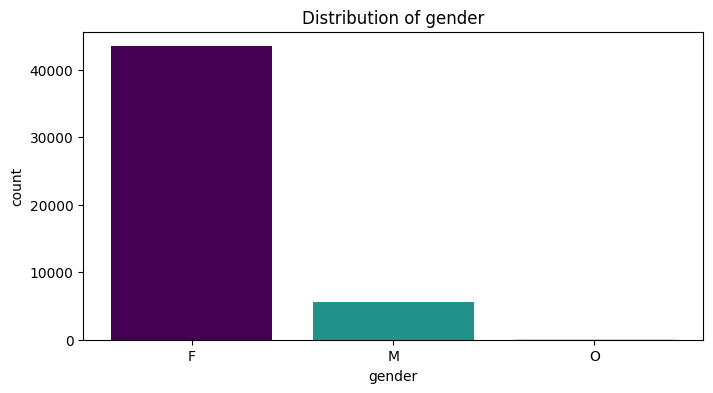

In [ ]:
# bar plot to show the values of 'gender'
# definition
counts = df_session_base['gender'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(counts)))

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(counts.index, counts.values, color=colors)

# labels
ax.set_xlabel("gender")
ax.set_ylabel("count")
ax.set_title("Distribution of gender")

# x-values
ax.set_xticks(counts.index)
ax.set_xticklabels(counts.index, rotation=0)

plt.show()

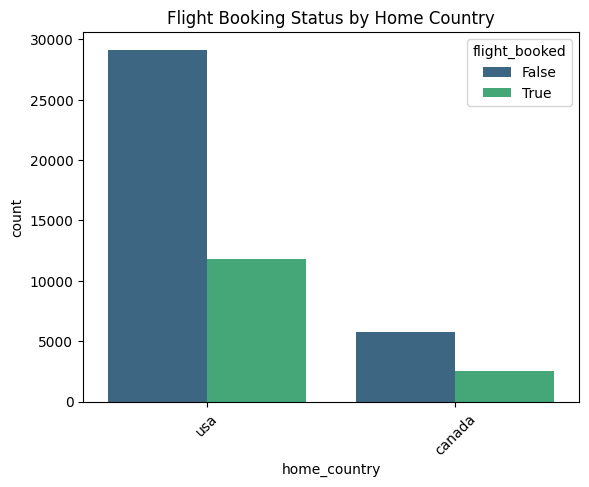

In [ ]:
# Overview of Home Country
sns.countplot(data=df_session_base, x="home_country", hue="flight_booked", palette="viridis")
plt.xticks(rotation=45)
plt.title("Flight Booking Status by Home Country")
plt.show()

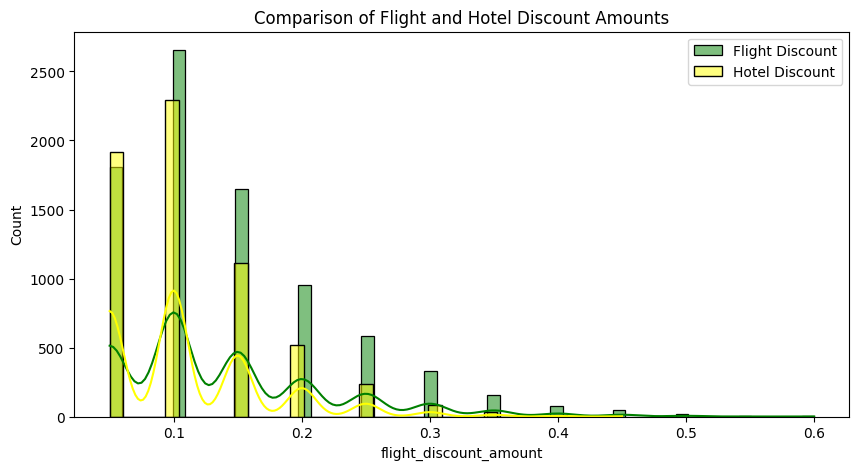

In [ ]:
# Comparison of Flight and Hotel Discount Amounts
plt.figure(figsize=(10, 5))
sns.histplot(df_session_base['flight_discount_amount'], kde=True, color='green', label='Flight Discount')
sns.histplot(df_session_base['hotel_discount_amount'], kde=True, color='yellow', label='Hotel Discount')
plt.legend()
plt.title("Comparison of Flight and Hotel Discount Amounts")
plt.show()

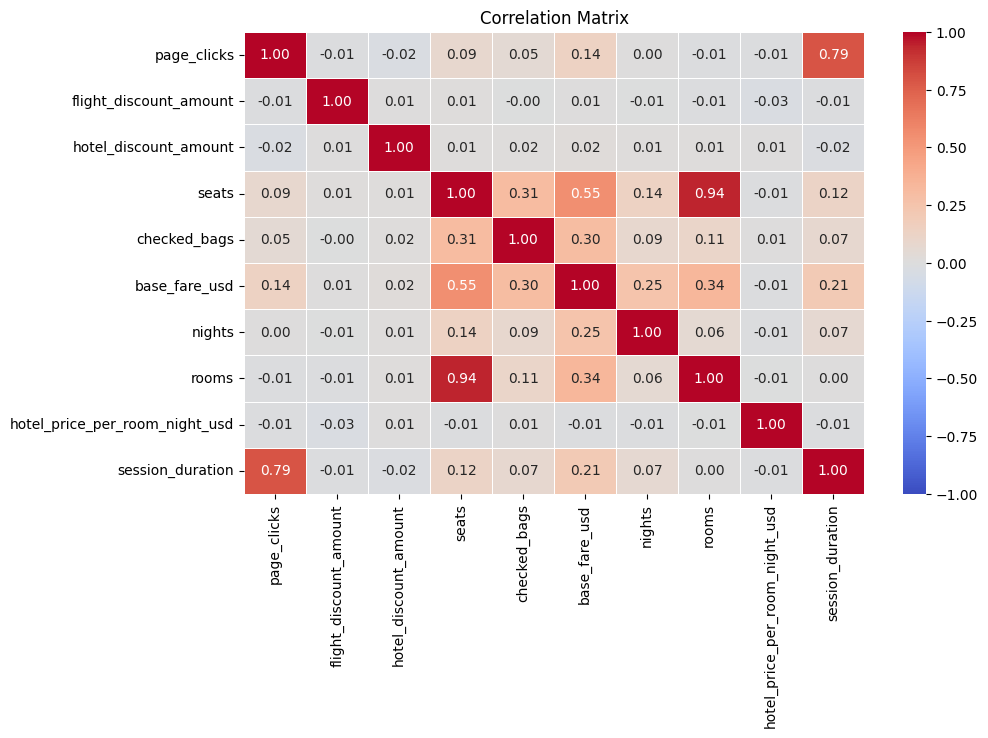

In [ ]:
# Corelation matrix for the user_base Dataframe with manual selected columns
numerical_cols = ['page_clicks', 'flight_discount_amount', 'hotel_discount_amount', 'seats', 'checked_bags', 'base_fare_usd', 'nights', 'rooms', 'hotel_price_per_room_night_usd', 'session_duration']
corr_table = df_session_base[numerical_cols]

corr_matrix = corr_table[numerical_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
#Overview of all numerical values
df_session_base.describe().T

,count,mean,min,25%,50%,75%,max,std
user_id,49211.0,545282.694946,23557.0,517119.0,540308.0,573922.0,844489.0,64640.047648
session_start,49211,2023-03-21 11:25:24.870191616,2023-01-04 00:01:00,2023-02-05 22:31:30,2023-03-09 11:04:00,2023-04-28 11:23:00,2023-07-28 19:58:52,NaN
session_end,49211,2023-03-21 11:28:32.122520320,2023-01-04 00:04:23,2023-02-05 22:34:10.500000,2023-03-09 11:06:35,2023-04-28 11:25:11.500000,2023-07-28 20:08:52,NaN
page_clicks,49211.0,17.588791,1.0,6.0,13.0,22.0,566.0,21.495987
flight_discount_amount,8282.0,0.139864,0.05,0.1,0.1,0.2,0.6,0.083914
hotel_discount_amount,6205.0,0.112192,0.05,0.05,0.1,0.15,0.45,0.062119
birthdate,49211,1982-02-26 19:15:57.371319424,1935-05-10 00:00:00,1974-09-08 00:00:00,1981-10-09 00:00:00,1989-03-16 00:00:00,2006-12-28 00:00:00,NaN
home_airport_lat,49211.0,38.427222,21.316,33.818,39.103,42.238,61.251,6.185962
home_airport_lon,49211.0,-94.183762,-157.927,-112.383,-90.035,-79.37,-63.499,18.065868
sign_up_date,49211,2023-01-20 00:56:58.357683968,2021-07-22 00:00:00,2023-01-08 00:00:00,2023-01-19 00:00:00,2023-02-05 00:00:00,2023-05-18 00:00:00,NaN


#<font color="mintblue">Findings of the analysis:

<font color="mintblue">1. Outlier identification: 'session_duration' includes high outliers

<font color="mintblue">2. Outlier identification: 'page_clicks' includes high outliers

<font color="mintblue">3. Invalid values in 'nights': Negative hotel stays exist






In [ ]:
# Boxplot and Histogram
def plot_distribution(df, column_name):
  """
  Plots a boxplot and a histogram for a given column in a DataFrame.

  Args:
    df: The pandas DataFrame.
    column_name: The name of the column to visualize.
  """
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Boxplot
  sns.boxplot(y=df[column_name], ax=axes[0], color="yellow")
  axes[0].set_title(f'Boxplot of {column_name}')

  # Histogram
  sns.histplot(df[column_name], ax=axes[1], kde=True, color="green")
  axes[1].set_title(f'Histogram of {column_name}')

  # Plot
  plt.tight_layout()
  plt.show()

#<font color="mintblue">1.2.1 Outliers removing</font>

<font color="mintblue">Outliers are analyzed by using box plots and histograms and then deleted by using the IQR method.

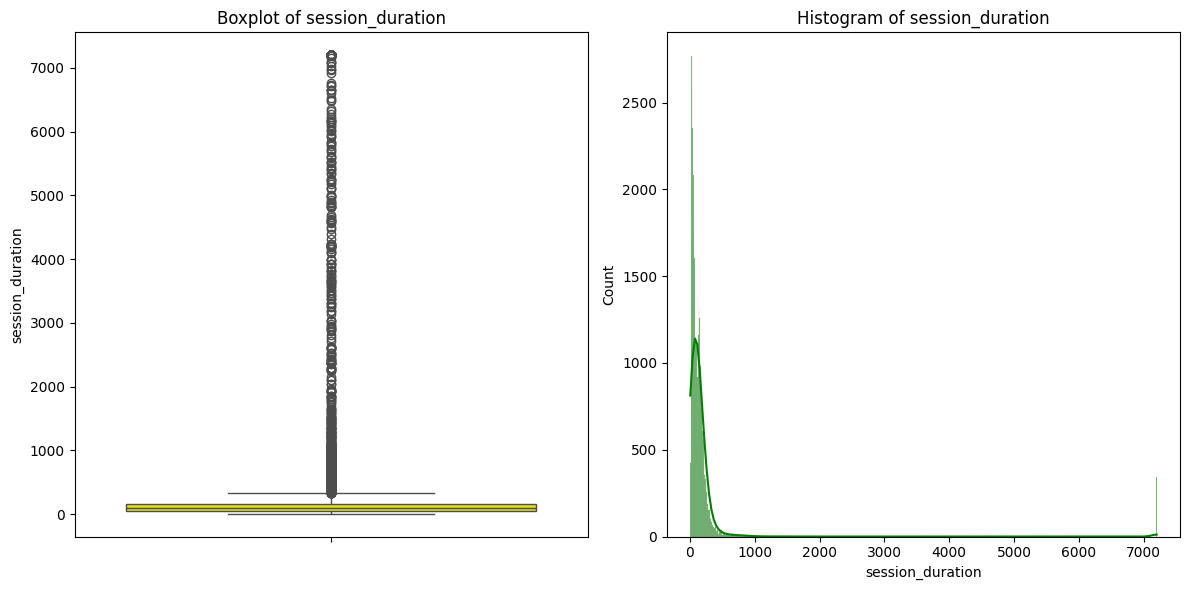

In [ ]:
# Plot before cleanup
plot_distribution(df_session_base, 'session_duration')

In [ ]:
def remove_outliers_iqr(df, column_name):
  """
  Removes outliers from a specified column in a DataFrame using the IQR method.

  Args:
    df: The pandas DataFrame.
    column_name: The name of the column to remove outliers from.

  Returns:
    A new DataFrame with outliers removed.
  """
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 5 * IQR
  upper_bound = Q3 + 5 * IQR

  original_rows = df.shape[0]
  df_cleaned = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)].copy()
  removed_rows = original_rows - df_cleaned.shape[0]

  print(f"Removed {removed_rows} outliers from the '{column_name}' column.")

  return df_cleaned

Removed 831 outliers from the 'session_duration' column.


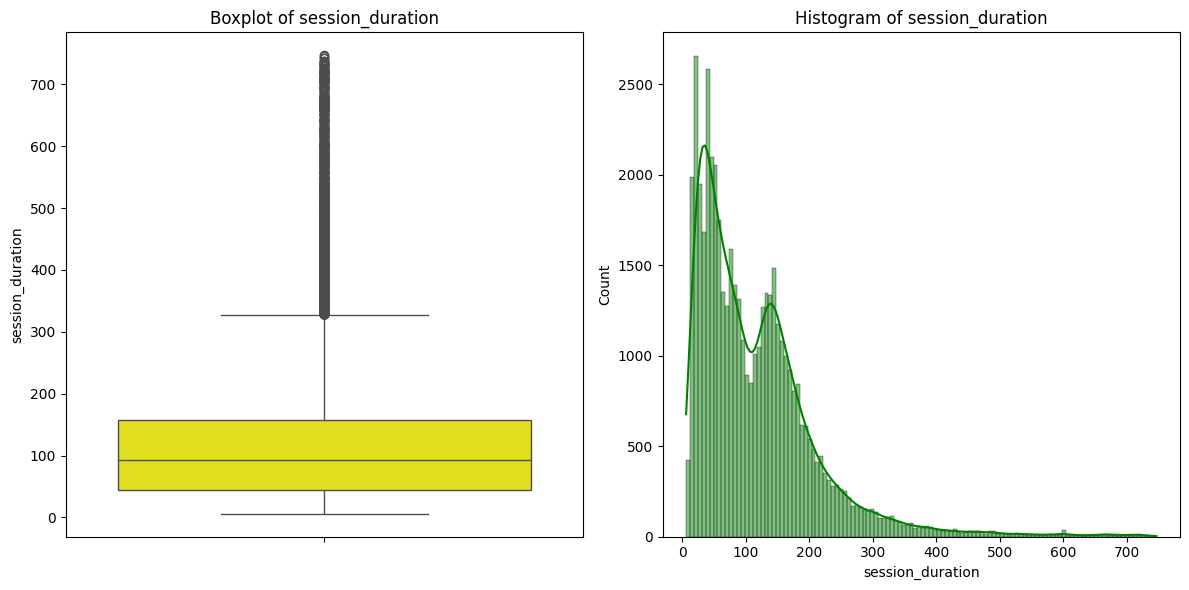

In [ ]:
# Plot after removing the ouliers with the IQR Methode
df_cleaned = remove_outliers_iqr(df_session_base, 'session_duration')
plot_distribution(df_cleaned, 'session_duration')

#<font color="mintblue">1.2.2 Outliers clipping

<font color="mintblue">Outliers are analyzed by using box plots and histograms.
Instead of deleting the outliers, we can consider setting lower and upper limits and then clipping them by using the IQR method.
This result leads to less loss of information.


In [ ]:
def clip_outliers_iqr(df, column_name):
  """
  Clipping outliers from a specified column in a DataFrame using the IQR method.

  Args:
    df: The pandas DataFrame.
    column_name: The name of the column to clip outliers from.

  Returns:
    A new DataFrame with outliers clipped.
  """
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 5 * IQR
  upper_bound = Q3 + 5 * IQR

  df_clipped = df.copy()
  df_clipped[column_name] = df_clipped[column_name].clip(lower_bound, upper_bound)

  print(f"Clipped outliers from the '{column_name}' column.")

  return df_clipped

In [ ]:
# clip outliers
df_session_clip = clip_outliers_iqr(df_session_base, "page_clicks")
df_session_clip = clip_outliers_iqr(df_session_clip, "session_duration")
# remove outliers
df_session_rm = remove_outliers_iqr(df_session_base, "page_clicks")
df_session_rm = remove_outliers_iqr(df_session_rm, "session_duration")

Clipped outliers from the 'page_clicks' column.
Clipped outliers from the 'session_duration' column.
Removed 605 outliers from the 'page_clicks' column.
Removed 241 outliers from the 'session_duration' column.


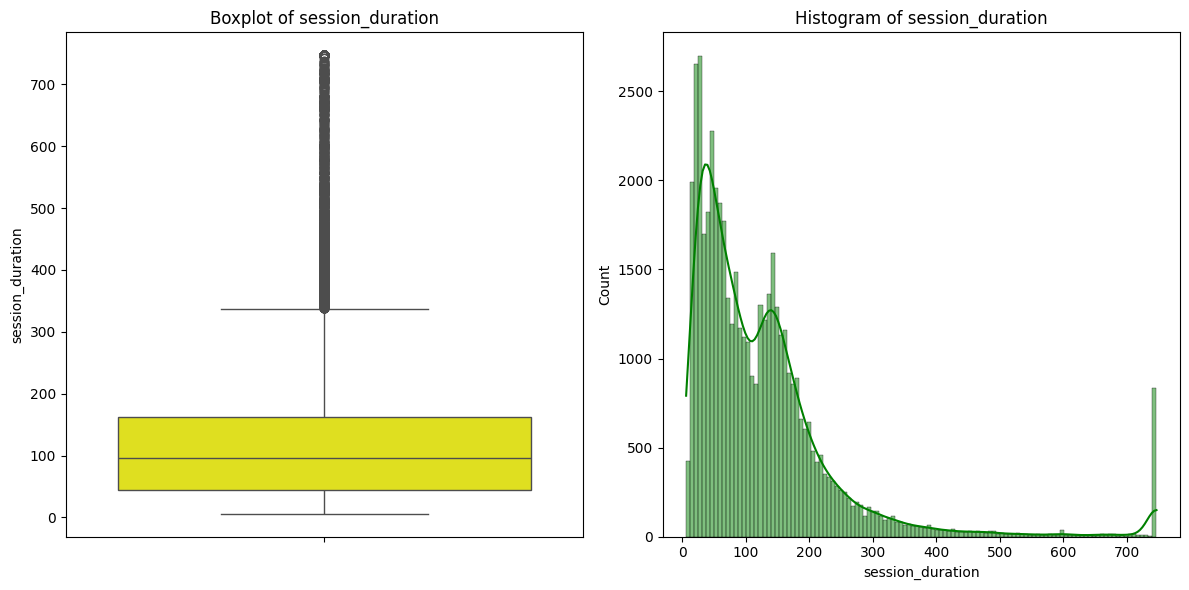

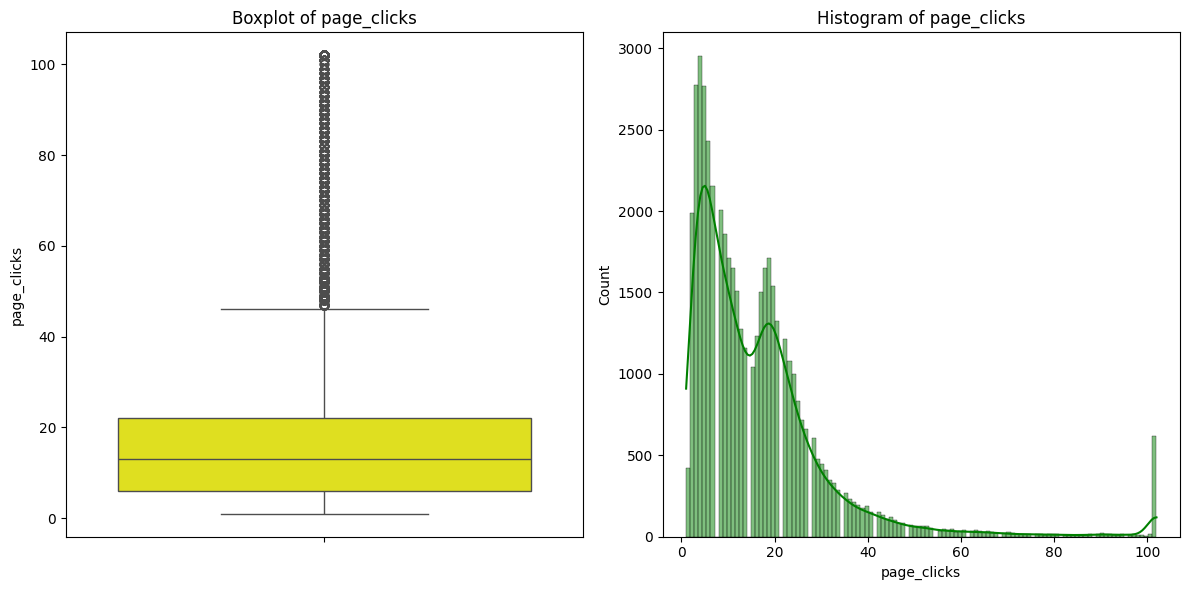

In [ ]:
# Plot: clip outliers
plot_distribution(df_session_clip, 'session_duration')
plot_distribution(df_session_clip, 'page_clicks')
# Plot: remove outliers
#plot_distribution(df_session_rm, 'session_duration')
#plot_distribution(df_session_rm, 'page_clicks')


#<font color="mintblue">1.2.3 Cleaning: negative Hotel-Nights</font>

<font color="mintblue">Solution for the cleanup:
All hotel nights with a value <= 0 are set to 1

In [ ]:
#print: negative nights
df_session_base[df_session_base['nights'] <= 0][['user_id', 'nights', 'check_in_time', 'check_out_time', 'departure_time', 'return_time']]

,user_id,nights,check_in_time,check_out_time,departure_time,return_time
2177,665593,-1,2023-07-07 14:11:49.380,2023-07-07 11:00:00,2023-07-07 09:00:00,2023-07-08 09:00:00
2506,500974,0,2023-01-26 14:01:28.335,2023-01-27 11:00:00,2023-01-26 07:00:00,2023-01-27 07:00:00
5344,501735,0,2023-03-03 12:36:20.070,2023-03-04 11:00:00,2023-03-03 08:00:00,2023-03-04 08:00:00
7077,549472,0,2023-02-17 09:40:11.865,2023-02-17 11:00:00,2023-02-17 07:00:00,2023-02-18 07:00:00
7659,553805,0,2023-03-27 12:03:48.825,2023-03-28 11:00:00,2023-03-27 08:00:00,2023-03-29 08:00:00
...,...,...,...,...,...,...
49139,477730,0,2023-04-01 13:54:35.865,2023-04-02 11:00:00,2023-04-01 07:00:00,2023-04-03 07:00:00
49175,438406,0,2023-02-24 17:58:03.945,2023-02-25 11:00:00,2023-02-24 11:00:00,2023-02-25 11:00:00
49195,523273,-1,2023-01-20 19:18:09.990,2023-01-20 11:00:00,2023-01-20 14:00:00,2023-01-22 14:00:00
49196,532823,0,2023-01-24 18:53:39.705,2023-01-25 11:00:00,2023-01-24 14:00:00,2023-01-26 14:00:00


In [ ]:
#print: Check-OUT before Check-IN
df_session_base[df_session_base['check_out_time'] < df_session_base['check_in_time']][['user_id', 'nights', 'check_in_time', 'check_out_time', 'departure_time', 'return_time']]


,user_id,nights,check_in_time,check_out_time,departure_time,return_time
2177,665593,-1,2023-07-07 14:11:49.380,2023-07-07 11:00:00,2023-07-07 09:00:00,2023-07-08 09:00:00
22995,476714,0,2023-01-15 11:44:13.425,2023-01-15 11:00:00,2023-01-15 08:00:00,2023-01-16 08:00:00
32759,562886,-1,2023-02-05 12:40:44.535,2023-02-05 11:00:00,2023-02-05 10:00:00,2023-02-06 10:00:00
32823,372970,-1,2023-03-12 13:34:49.935,2023-03-12 11:00:00,2023-03-12 07:00:00,2023-03-13 07:00:00
32849,552363,0,2023-05-13 11:39:07.875,2023-05-13 11:00:00,2023-05-13 07:00:00,2023-05-15 07:00:00
...,...,...,...,...,...,...
48849,517732,-1,2023-01-19 13:52:45.840,2023-01-19 11:00:00,2023-01-19 07:00:00,2023-01-20 07:00:00
48895,663376,0,2023-06-14 11:00:27.360,2023-06-14 11:00:00,2023-06-14 07:00:00,2023-06-15 07:00:00
49118,510093,0,2023-07-30 11:45:27.810,2023-07-30 11:00:00,2023-07-30 07:00:00,2023-07-31 07:00:00
49132,665329,-1,2023-07-04 14:57:38.250,2023-07-04 11:00:00,2023-07-04 12:00:00,2023-07-05 12:00:00


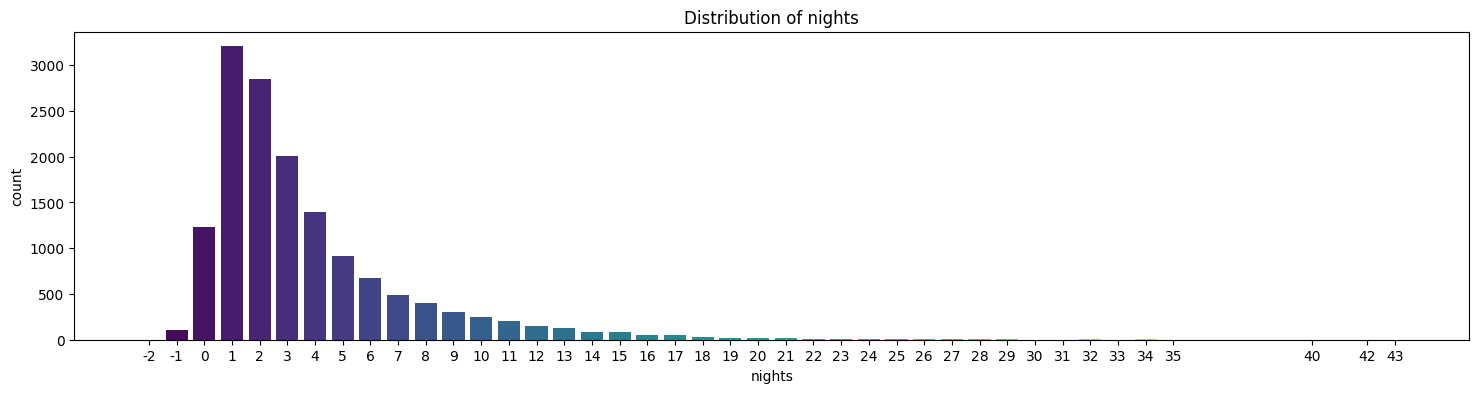

In [ ]:
# Before cleaning
# bar plot to show the values 'nights' in 'df_session'
# definition
counts = df_session_base['nights'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(counts)))

fig, ax = plt.subplots(figsize=(18, 4))
ax.bar(counts.index, counts.values, color=colors)

# labels
ax.set_xlabel("nights")
ax.set_ylabel("count")
ax.set_title("Distribution of nights")

# x-values
ax.set_xticks(counts.index)
ax.set_xticklabels(counts.index.astype(int), rotation=0)

plt.show()

In [ ]:
# all hotel 'nights' with a value x for 'x <= 0' are set to '1'
df_session_clip['nights'] = df_session_clip['nights'].apply(lambda x: 1 if x <= 0 else x)

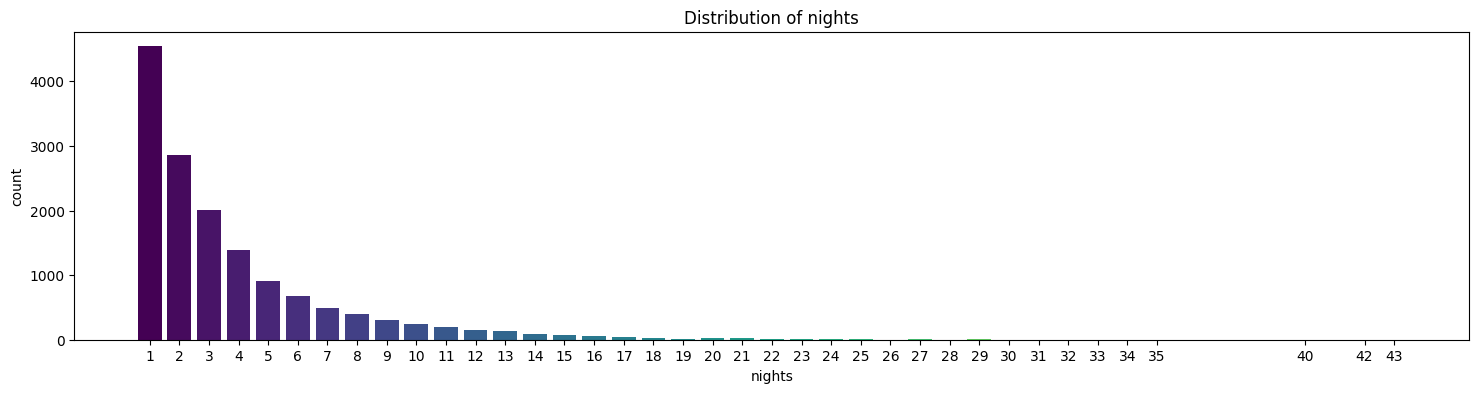

In [ ]:
# After cleaning
# bar plot to show the values 'nights' in 'df_session'
# definition
counts = df_session_clip['nights'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(counts)))

fig, ax = plt.subplots(figsize=(18, 4))
ax.bar(counts.index, counts.values, color=colors)

# labels
ax.set_xlabel("nights")
ax.set_ylabel("count")
ax.set_title("Distribution of nights")

# x-values
ax.set_xticks(counts.index)
ax.set_xticklabels(counts.index.astype(int), rotation=0)

plt.show()

#<font color="mintblue">1.3 CSV export for the cleaned data</font>

In [ ]:
# Export data
df_session_clip.to_csv(f'{directory}/session_base_cleaned.csv', index=False)
# rename 'df_session_clip' to 'df_session_base_cleaned'
df_session_base_cleaned = df_session_clip.copy()

#<font color="mintblue">2. Detection of canceled trips</font>

In [ ]:
df_session_base.shape

(49211, 42)

In [ ]:
# Display 'df_session' for all columns with the value 'cancellation==True'
df_canceled=df_session_base[df_session_base['cancellation']==True]
print(f'df_canceled shape: {df_canceled.shape}')
df_canceled[['session_id', 'cancellation', 'user_id', 'trip_id', 'base_fare_usd', 'hotel_price_per_room_night_usd']].T

df_canceled shape: (610, 42)


,6622,10543,12669,14756,14757,27054,27055,29160,29161,31080,...,49038,49066,49101,49119,49135,49146,49168,49169,49193,49194
session_id,513807-40598c950fe847dfa2968a2075cac65f,454934-9ab1661e94974d2088cc254093e3212d,498500-4f54c05abc824775937b6a61b322f400,520861-7b214544dd744c0e8d91ac9d6159f5d5,733654-11e10511179248a498f7a6041f34aa89,574003-c5242af0dc5347328dbf832e83aa6896,465731-d1b137221de847f29e9bf45ab1476452,411179-7a66cb2e947147e795e159a30ec350b5,407118-97ad178859d74d1db63e76cad2d0a22d,524448-d8f14d1175764428927818f3c99dd2cf,...,547100-9a3f6bafdcdb46a0aee5a1f0a21439f3,530514-7f54c1498e184b8b9544fe21d9c9f8fe,520947-1082965ab12744069c3a4d3c637ad7e7,480313-f46ac4d965a2410e84ddf400ede116ad,511977-db543caa120c4a6e939a3b4ebc8b8c02,486751-8cd2671966064db4b5b3681ebb6530dd,565565-e7c0f5dc960f44bab15fa835e483ddce,640689-f021e246e24543b78bae3786ebfe802e,438551-f1073b8a5a844032a33256666ee6c47f,542095-22cca89073d644189eae13fedfb9ff47
cancellation,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
user_id,513807,454934,498500,520861,733654,574003,465731,411179,407118,524448,...,547100,530514,520947,480313,511977,486751,565565,640689,438551,542095
trip_id,513807-3c80157290d341feac1def60567b019c,454934-2b0809d98c0a466ab8f1502d8c229ffc,498500-8625a588e269412d9c6ac9ddbbb19a9d,520861-df209855e39a4b3c93cc547763a87ea2,733654-777d480b8d09486189720f37e154f60c,574003-3e720124b2d04e9d80a8efff6a89eb1f,465731-71a801a4c6214bf2b4ecb0bc56dc3fd7,411179-3e79bf8334914815b7dc005dc0ebd89a,407118-a6af8ef4d8ba478b8716bbb77848346e,524448-944c2290892747b5b22b8907d23694be,...,547100-c11a039eff2348da975f7f853f138d6f,530514-84a33f84402b474297225a09832b3b03,520947-83843cd2814a4b48b62399969dfa5c60,480313-129a85cc3c5244b5962afe10c7932cda,511977-6cfb80ba6d0543378ec2b63c0af11d64,486751-ac8269b44cf44e37a344c955f34f6146,565565-5fcbfd8953e14ddeb5b4d17878327b11,640689-fc78829e4e6a429bb139e27e751090a4,438551-1a9fcfc16bd8487ea23e820957d23279,542095-da1172e2431342eba39c1630cbf81673
base_fare_usd,903.26,141.89,540.88,429.4,172.51,1078.56,613.9,202.92,837.83,327.19,...,4354.66,<NA>,409.1,83.44,1864.5,608.48,<NA>,327.04,13645.96,283.94
hotel_price_per_room_night_usd,<NA>,220,193,<NA>,247,<NA>,97,310,126,167,...,75,57,181,174,<NA>,177,149,149,143,218


In [ ]:
# Create 'df_not_canceled_trips':
# Step1: All lines with 'trip_id' from 'df_canceled' are deleted in 'df_session'
df_not_canceled_trips=df_session_base[~df_session_base['trip_id'].isin(df_canceled['trip_id'])]
print(f'df_not_canceled_trips shape: {df_not_canceled_trips.shape}')
df_not_canceled_trips[['session_id', 'cancellation', 'user_id', 'trip_id', 'base_fare_usd', 'hotel_price_per_room_night_usd']].T

df_not_canceled_trips shape: (47998, 42)


,0,1,2,3,4,5,6,7,8,9,...,49200,49201,49202,49203,49204,49206,49207,49208,49209,49210
session_id,485505-1be61034443046e8bee53062f5df8331,488865-a1751f08d42846fa9ae07c5c1a386cbf,520959-e6b1a47fab3b4ef9a04d42c22626a39e,531971-ad9838efa4d4467fae4d4d13cdd5a9e8,562814-de6c278c8a154b79a4959d95993b8674,625398-9ab75fedd8114666b15433f7f3f792be,630694-48d8aec4be8f42079abbce6a7410610b,340166-ad29a74af69247389e970740e5eee50d,514342-76399f9b99fa4eeeb0df71a47a42296a,544549-79437112198f447ab5bc8659b144456d,...,512556-2ca5fa4d3d77424582d639babc982081,635303-9aba35e6100348158cb97ba9c4651e16,618759-3932f40871ee4e3a91e3bd3f9d176413,560897-cd2ac0276b7a488991bc92e2dcaab3e6,533155-62d53870063246c5b2263a49c6b38d7d,550426-4f92fcb88ebd4854ba998a60ab70500a,610793-d7c5924dcfac43e0b19211370af6c794,503928-df055d6f1b804da4a47ab8ddd72c2724,635303-bb3b3a5bbbd64a6a838195880599849b,623935-7098484783d84e70bd2fdacaace76772
cancellation,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
user_id,485505,488865,520959,531971,562814,625398,630694,340166,514342,544549,...,512556,635303,618759,560897,533155,550426,610793,503928,635303,623935
trip_id,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,512556-3a36970290da41daa3399fcd1ab19ab1,635303-997e40b6c47e4bdf9ca4a81b15928afe,618759-bbae71ac4f2e471fb14d284552058b24,560897-0324dbce2c1a4cf688e3b7fda1bef0e7,533155-5a10ff84230a4e0698144c9696e4f14c,550426-4ee1b21f6b0148f1804e0536278de146,610793-b0ad9fd46383491aa91f23c002af6300,503928-163e7cd17a4d46b3b37c17b71a110a02,635303-dd4a04548f3648e39ab678372d6bddb5,623935-7b26725692ab4557a272fa4cfd028cf7
base_fare_usd,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,1091.54,905.34,117.77,248.59,703.96,63.96,402.16,362.41,1942.64,<NA>
hotel_price_per_room_night_usd,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,284,<NA>,<NA>,72,94,614,198,222,530,93


In [ ]:
# Create 'df_not_canceled_trips':
# Step2: Delete all lines from 'df_not_canceled_trips' where no trip_id is present
df_not_canceled_trips=df_not_canceled_trips.dropna(subset=['trip_id'])
print(f'df_not_canceled_trips shape: {df_not_canceled_trips.shape}')
df_not_canceled_trips[['session_id', 'cancellation', 'user_id', 'trip_id', 'base_fare_usd', 'hotel_price_per_room_night_usd']].T

df_not_canceled_trips shape: (15489, 42)


,79,364,431,462,693,776,1144,1164,1250,1772,...,49200,49201,49202,49203,49204,49206,49207,49208,49209,49210
session_id,570279-7d86b66f8f0b468c90d9553291a4a281,541084-912b0968a57647b9955d46f660febd07,512201-c703668166734621b079fc8a366db203,517491-49ed255542d142c4b2b6b54c20201e36,488865-be40c5dcccd44022bd701f93ed83c929,560978-02a809eca12d4bffbca9d0deb2eb5771,542012-004deaac3341435f95193d20c1db24e1,600078-cd52591b4dcd4dd89779db6b7d1a5042,283325-eed61ca33de3458a9134d3d743f17722,530801-3f8db46473804f22a1bed8f249cc07e0,...,512556-2ca5fa4d3d77424582d639babc982081,635303-9aba35e6100348158cb97ba9c4651e16,618759-3932f40871ee4e3a91e3bd3f9d176413,560897-cd2ac0276b7a488991bc92e2dcaab3e6,533155-62d53870063246c5b2263a49c6b38d7d,550426-4f92fcb88ebd4854ba998a60ab70500a,610793-d7c5924dcfac43e0b19211370af6c794,503928-df055d6f1b804da4a47ab8ddd72c2724,635303-bb3b3a5bbbd64a6a838195880599849b,623935-7098484783d84e70bd2fdacaace76772
cancellation,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
user_id,570279,541084,512201,517491,488865,560978,542012,600078,283325,530801,...,512556,635303,618759,560897,533155,550426,610793,503928,635303,623935
trip_id,570279-c48e05a90f9c44e8beb667ba9cc1f8a0,541084-2855d56d85854717a7eacf9a63dce35f,512201-d198cb30dbe945a58808812558288792,517491-f17c9a923a054db2955c3f56a7d8486e,488865-1154619ac9b34950b501ead668e4e825,560978-2d58a08a54cd4be1868835db447692f7,542012-e368760a3dd34190ac40531d5383ec19,600078-94092124e6b64001808a3a089ecc4fb0,283325-dd763c2d6d334b3790266b500393438e,530801-c1984101944049c3981bca433393ae12,...,512556-3a36970290da41daa3399fcd1ab19ab1,635303-997e40b6c47e4bdf9ca4a81b15928afe,618759-bbae71ac4f2e471fb14d284552058b24,560897-0324dbce2c1a4cf688e3b7fda1bef0e7,533155-5a10ff84230a4e0698144c9696e4f14c,550426-4ee1b21f6b0148f1804e0536278de146,610793-b0ad9fd46383491aa91f23c002af6300,503928-163e7cd17a4d46b3b37c17b71a110a02,635303-dd4a04548f3648e39ab678372d6bddb5,623935-7b26725692ab4557a272fa4cfd028cf7
base_fare_usd,91.29,<NA>,781.52,155.67,350.46,4589.44,294.61,183.01,453.27,620.71,...,1091.54,905.34,117.77,248.59,703.96,63.96,402.16,362.41,1942.64,<NA>
hotel_price_per_room_night_usd,78,112,171,154,142,299,419,<NA>,527,291,...,284,<NA>,<NA>,72,94,614,198,222,530,93


In [ ]:
# Show results
print(f'Number of canceled trips: {len(df_canceled)}')
print(f'Number of not canceled trips: {len(df_not_canceled_trips)}')

Number of canceled trips: 610
Number of not canceled trips: 15489


#<font color="mintblue">2.1. CSV export for not canceled trips</font>

In [ ]:
# CSV export
df_not_canceled_trips.to_csv(f'{directory}/not_canceled_trips.csv', index=False)

In [ ]:
# Reload DF
df_session_base = pd.read_csv(directory + "/session_base_cleaned.csv")
df_trips = pd.read_csv(directory + "/not_canceled_trips.csv")

#<font color="mintblue">3. Feature Engineering</font>

In [ ]:
# Convert all columns in df_trips to the best possible pandas dtypes
df_trips = df_trips.convert_dtypes()

# Convert all columns in df_session_base to the best possible pandas dtypes
df_session_base = df_session_base.convert_dtypes()

# List of columns that should be parsed as datetime
cols = [
    'session_start',
    'session_end',
    'birthdate',
    'sign_up_date',
    'departure_time',
    'return_time',
    'check_in_time',
    'check_out_time'
]

# Loop over each column in the list
for c in cols:
    # Convert the column in df_trips to datetime, allowing mixed date formats
    df_trips[c] = pd.to_datetime(df_trips[c], format='mixed')

    # Convert the same column in df_session_base to datetime, allowing mixed date formats
    df_session_base[c] = pd.to_datetime(df_session_base[c], format='mixed')

# Rename DF
df_session = df_session_base.copy()

#<font color="mintblue">3.1 Feature Engineering of DataFrame 'df_session'</font>

In [ ]:
# Create the Feature 'empty_session' and preparing the NaN values ​​for aggregation
df_session['empty_session'] = df_session['trip_id'].isna().astype(int)

In [ ]:
# Create the Feature 'canceled_trip'

# Get all unique trip IDs from df_trips (e.g. non-canceled trips)
nc_trip_ids = df_trips['trip_id'].unique()

# Get all unique, non-null trip IDs from df_session and remove rows where trip_id is NaN
total_trip_ids = (df_session.dropna(subset=['trip_id'])['trip_id'].unique())

# Find trip IDs that appear in sessions but NOT in 'df_trips'
# These are interpreted as canceled trips
canceled_trip_ids = total_trip_ids[~pd.Series(total_trip_ids).isin(nc_trip_ids)]

# Print out the Check
print(f'Number of canceled Trips {len(canceled_trip_ids)}, number of not canceled trips {len(nc_trip_ids)}')
# Set 'canceled_trip' = 1 if the 'trip_id' appears in 'canceled_trip_ids'
df_session['canceled_trip'] = df_session_base['trip_id'].isin(canceled_trip_ids).astype(int)

Number of canceled Trips 610, number of not canceled trips 15489


In [ ]:
# Show new Features in df_session
df_session[['session_id', 'trip_id','empty_session', 'canceled_trip']]


,session_id,trip_id,empty_session,canceled_trip
0,485505-1be61034443046e8bee53062f5df8331,<NA>,1,0
1,488865-a1751f08d42846fa9ae07c5c1a386cbf,<NA>,1,0
2,520959-e6b1a47fab3b4ef9a04d42c22626a39e,<NA>,1,0
3,531971-ad9838efa4d4467fae4d4d13cdd5a9e8,<NA>,1,0
4,562814-de6c278c8a154b79a4959d95993b8674,<NA>,1,0
...,...,...,...,...
49206,550426-4f92fcb88ebd4854ba998a60ab70500a,550426-4ee1b21f6b0148f1804e0536278de146,0,0
49207,610793-d7c5924dcfac43e0b19211370af6c794,610793-b0ad9fd46383491aa91f23c002af6300,0,0
49208,503928-df055d6f1b804da4a47ab8ddd72c2724,503928-163e7cd17a4d46b3b37c17b71a110a02,0,0
49209,635303-bb3b3a5bbbd64a6a838195880599849b,635303-dd4a04548f3648e39ab678372d6bddb5,0,0


#<font color="mintblue">3.2 Feature Engineering of the DataFrame 'df_trips'</font>

In [ ]:
# collect number of Flights per Booking
df_trips['num_flights'] = np.where(
    #statement
    (df_trips['flight_booked'] == True) & (df_trips['return_flight_booked'] == True),
    #when True
    2,
    #When False
    np.where(
        (df_trips['flight_booked'] == True) & (df_trips['return_flight_booked'] == False),1,0
    )
)

# Flag on discount trip
df_trips['discount_trip'] = np.where(
    #if statement
    (df_trips['flight_discount']== True) | (df_trips['hotel_discount'] == True), 1, 0
)

# Calculate Money Spent per Flight applying the discount only if a discount was used
df_trips['money_spent_per_flight'] = np.where(
    #has coupon
    (df_trips['flight_discount'] == True),
    #when True
    df_trips['base_fare_usd'] * (1 - df_trips['flight_discount_amount']),
    #else
    df_trips['base_fare_usd']
)

# Costs per Seat per Flight
df_trips['money_spent_per_seat'] = df_trips['money_spent_per_flight'] / df_trips['seats']

# Money Spent per Hotel applying the discount only if a discount was used
df_trips['hotel_total_price'] = df_trips['hotel_price_per_room_night_usd'] * df_trips['nights'] * df_trips['rooms']
df_trips['money_spent_per_hotel'] = np.where(
    #has coupon
    (df_trips['hotel_discount'] == True),
    #when True
    df_trips['hotel_total_price'] * (1 - df_trips['hotel_discount_amount']),
    #when False
    df_trips['hotel_total_price']
)

# Time After booking (days between the exit of a session and the time of departure or check in)
df_trips['time_after_booking'] = np.where(
    #if booking was in combination with a flight
    (df_trips['flight_booked'] == True),
    #take flight date
    (df_trips['departure_time'] - df_trips['session_end']).dt.days,
    #hotel only -> take check in time
    (df_trips['check_in_time'] - df_trips['session_end']).dt.days
)

# Identify whether the user traveled alone or with companions
# travel_companion = 1 if the trip involved more than one seat or room, otherwise 0
df_trips['travel_companion'] = np.where(
    ((df_trips['flight_booked'] == True) & (df_trips['seats'] > 1)) | ((df_trips['hotel_booked'] == True) & (df_trips['rooms'] > 1)),
    1,  # traveled with companions
    0   # traveled alone
)


In [ ]:
# Display the new Features
df_trips[['session_id', 'trip_id', 'num_flights', 'discount_trip', 'money_spent_per_flight', 'money_spent_per_seat', 'money_spent_per_hotel', 'time_after_booking', 'travel_companion']].T

,0,1,2,3,4,5,6,7,8,9,...,15479,15480,15481,15482,15483,15484,15485,15486,15487,15488
session_id,570279-7d86b66f8f0b468c90d9553291a4a281,541084-912b0968a57647b9955d46f660febd07,512201-c703668166734621b079fc8a366db203,517491-49ed255542d142c4b2b6b54c20201e36,488865-be40c5dcccd44022bd701f93ed83c929,560978-02a809eca12d4bffbca9d0deb2eb5771,542012-004deaac3341435f95193d20c1db24e1,600078-cd52591b4dcd4dd89779db6b7d1a5042,283325-eed61ca33de3458a9134d3d743f17722,530801-3f8db46473804f22a1bed8f249cc07e0,...,512556-2ca5fa4d3d77424582d639babc982081,635303-9aba35e6100348158cb97ba9c4651e16,618759-3932f40871ee4e3a91e3bd3f9d176413,560897-cd2ac0276b7a488991bc92e2dcaab3e6,533155-62d53870063246c5b2263a49c6b38d7d,550426-4f92fcb88ebd4854ba998a60ab70500a,610793-d7c5924dcfac43e0b19211370af6c794,503928-df055d6f1b804da4a47ab8ddd72c2724,635303-bb3b3a5bbbd64a6a838195880599849b,623935-7098484783d84e70bd2fdacaace76772
trip_id,570279-c48e05a90f9c44e8beb667ba9cc1f8a0,541084-2855d56d85854717a7eacf9a63dce35f,512201-d198cb30dbe945a58808812558288792,517491-f17c9a923a054db2955c3f56a7d8486e,488865-1154619ac9b34950b501ead668e4e825,560978-2d58a08a54cd4be1868835db447692f7,542012-e368760a3dd34190ac40531d5383ec19,600078-94092124e6b64001808a3a089ecc4fb0,283325-dd763c2d6d334b3790266b500393438e,530801-c1984101944049c3981bca433393ae12,...,512556-3a36970290da41daa3399fcd1ab19ab1,635303-997e40b6c47e4bdf9ca4a81b15928afe,618759-bbae71ac4f2e471fb14d284552058b24,560897-0324dbce2c1a4cf688e3b7fda1bef0e7,533155-5a10ff84230a4e0698144c9696e4f14c,550426-4ee1b21f6b0148f1804e0536278de146,610793-b0ad9fd46383491aa91f23c002af6300,503928-163e7cd17a4d46b3b37c17b71a110a02,635303-dd4a04548f3648e39ab678372d6bddb5,623935-7b26725692ab4557a272fa4cfd028cf7
num_flights,2,0,2,2,2,2,2,2,2,2,...,2,2,2,1,2,2,2,2,2,0
discount_trip,0,1,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
money_spent_per_flight,91.29,NaN,781.52,155.67,350.46,4589.44,279.8795,183.01,407.943,620.71,...,1091.54,905.34,117.77,248.59,703.96,63.96,402.16,362.41,1942.64,NaN
money_spent_per_seat,91.29,<NA>,781.52,155.67,350.46,2294.72,279.8795,183.01,407.943,620.71,...,363.846667,452.67,117.77,248.59,703.96,63.96,402.16,362.41,647.546667,<NA>
money_spent_per_hotel,468.0,784.0,1231.2,462.0,284.0,4784.0,419.0,NaN,2108.0,582.0,...,5964.0,NaN,NaN,144.0,94.0,3070.0,594.0,222.0,4770.0,2232.0
time_after_booking,6.0,7.0,8.0,4.0,10.0,56.0,10.0,2.0,5.0,5.0,...,8.0,8.0,5.0,6.0,6.0,6.0,5.0,4.0,10.0,3.0
travel_companion,0,0,0,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,1,1


In [ ]:
# Create a feature witch shows the travel season of a trip using OneHotEncoder
def season_helper(row):
  time = row['departure_time'] if row['flight_booked'] else row['check_in_time']
  #month between 1 and 12
  if time.month in [1, 2, 12]:
    return 'winter'
  elif time.month in [3,4,5]:
    return 'spring'
  elif time.month in [6,7,8]:
    return 'summer'
  else:
    return 'fall'

df_trips['season'] = df_trips.apply(season_helper, axis=1)

In [ ]:
#sklearn OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_seasons = encoder.fit_transform(df_trips[['season']])
df_encoded = pd.DataFrame(encoded_seasons, columns=encoder.get_feature_names_out(['season']))
df_trips = pd.concat([df_trips, df_encoded], axis=1)

In [ ]:
# Function: Calculate distance between 2 locations with latitude and longitude coordinates
def haversine_distance(lat1, lon1, lat2, lon2):

    # Return NaN if any of the coordinates are missing
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return np.nan

    # Radius of the Earth in kilometers
    R = 6371

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Compute differences in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    # a is the square of half the chord length between the points
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2

    # c is the angular distance in radians
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = round(R * c,1)
    return distance


In [ ]:
# Create the feature which shows the flight distance in km
df_trips['distance_km'] = df_trips.apply(lambda row: haversine_distance(row['home_airport_lat'], row['home_airport_lon'],
                                                                        row['destination_airport_lat'], row['destination_airport_lon']), axis= 1)


In [ ]:
# Test the feature 'distance_km'
df_trips[['distance_km', 'flight_booked' ]]

,distance_km,flight_booked
0,540.0,True
1,NaN,False
2,4124.8,True
3,1045.3,True
4,1868.7,True
...,...,...
15484,399.8,True
15485,2001.2,True
15486,1789.6,True
15487,3974.2,True


In [ ]:
# Display DataFrame 'df_trips'
df_trips.head().T

,0,1,2,3,4
session_id,570279-7d86b66f8f0b468c90d9553291a4a281,541084-912b0968a57647b9955d46f660febd07,512201-c703668166734621b079fc8a366db203,517491-49ed255542d142c4b2b6b54c20201e36,488865-be40c5dcccd44022bd701f93ed83c929
user_id,570279,541084,512201,517491,488865
trip_id,570279-c48e05a90f9c44e8beb667ba9cc1f8a0,541084-2855d56d85854717a7eacf9a63dce35f,512201-d198cb30dbe945a58808812558288792,517491-f17c9a923a054db2955c3f56a7d8486e,488865-1154619ac9b34950b501ead668e4e825
session_start,2023-05-19 19:32:00,2023-07-11 05:27:00,2023-01-05 15:20:00,2023-01-08 15:23:00,2023-01-25 15:56:00
session_end,2023-05-19 19:34:50,2023-07-11 05:28:30,2023-01-05 15:22:34,2023-01-08 15:25:44,2023-01-25 15:58:19
page_clicks,23,12,21,22,19
flight_discount,False,True,False,False,False
flight_discount_amount,<NA>,0.2,<NA>,<NA>,<NA>
hotel_discount,False,False,True,False,False
hotel_discount_amount,<NA>,<NA>,0.1,<NA>,<NA>


#<font color="mintblue">3.3 Feature Engineering of the DataFrame 'df_user'</font>

<font color="mintblue">To create a final user-level DataFrame, some intermediate DataFrames are constructed in several steps to consolidate data from various sources. These intermediate DataFrames are subsequently merged to form a single, comprehensive final DataFrame.</font>

#<font color="mintblue">3.3.1 Feature Engineering of 'df_user_1'</font>

In [ ]:
# Create the user-level DataFrame 'df_user_1' by grouping 'df_session' on 'user_id'
# and aggregating behavioral features per user
df_user_1 = df_session.groupby('user_id').agg(
    num_clicks = ('page_clicks', 'sum'),
    avg_clicks_per_session = ('page_clicks', 'mean'),
    avg_session_duration = ('session_duration', 'mean'),
    num_sessions = ('session_id', 'count'),
    empty_sessions = ('empty_session', 'sum'),
    canceled_trips = ('canceled_trip', 'sum')
).reset_index()

# Display the first rows of 'df_user' where 'canceled_trips' is greater than 0
df_user_1[df_user_1['canceled_trips'] > 0].head()


,user_id,num_clicks,avg_clicks_per_session,avg_session_duration,num_sessions,empty_sessions,canceled_trips
4,106907,240,30.0,241.5,8,6,2
15,171470,250,31.25,229.25,8,5,3
16,174997,199,24.875,185.125,8,5,1
19,182191,148,18.5,156.625,8,7,1
24,204943,257,32.125,236.875,8,1,2


#<font color="mintblue">3.3.2 Feature Engineering of 'df_user_2'</font>

In [ ]:
# Create the user-level DataFrame 'df_user_2' by grouping 'df_trips' on 'user_id'
# and aggregating behavioral features per user
df_user_2 = df_trips.groupby('user_id').agg(
    num_trips = ('trip_id', 'count'),
    num_flights = ('num_flights', 'sum'),
    num_hotels = ('hotel_booked', 'sum'),
    num_discount_trips = ('discount_trip', 'sum'),
    avg_money_spent_per_flight = ('money_spent_per_flight', 'mean'),
    avg_money_spent_per_seat = ('money_spent_per_seat', 'mean'),
    avg_money_spent_per_hotel = ('money_spent_per_hotel', 'mean'),
    avg_time_after_booking = ('time_after_booking', 'mean'),
    num_travel_companion_trips = ('travel_companion', 'sum'),
    avg_distance_per_flight_km = ('distance_km','mean'),
    avg_seats_per_flight = ('seats', 'mean'),
    avg_nights_per_hotel = ('nights', 'mean'),
    avg_rooms_per_hotel = ('rooms', 'mean'),
    avg_bags = ('checked_bags', 'mean')
).reset_index()

# Display the first rows of 'df_user_2' where 'num_trips' > 7
df_user_2[df_user_2['num_trips'] > 7].head()

,user_id,num_trips,num_flights,num_hotels,num_discount_trips,avg_money_spent_per_flight,avg_money_spent_per_seat,avg_money_spent_per_hotel,avg_time_after_booking,num_travel_companion_trips,avg_distance_per_flight_km,avg_seats_per_flight,avg_nights_per_hotel,avg_rooms_per_hotel,avg_bags
426,485544,8,16,7,2,920.737062,456.178313,871.000000,6.750,3,2647.200000,1.875,3.714286,2.0,0.375
745,509115,8,10,7,2,765.459100,566.23655,1034.285714,4.750,2,3304.700000,1.4,4.571429,1.285714,1.0
1086,513236,8,11,8,1,551.131667,291.213333,1040.375000,5.625,3,1753.116667,1.666667,3.875,1.625,0.166667
1384,517491,8,12,7,0,328.926667,328.926667,813.428571,7.250,1,1839.416667,1.0,3.571429,1.142857,0.5
4071,572554,8,12,6,2,270.091833,233.2935,626.500000,7.875,1,1293.250000,1.166667,3.333333,1.166667,0.833333


#<font color="mintblue">3.3.3 Feature Engineering of 'df_user_3'</font>

In [ ]:
# Create the user-level DataFrame 'df_user_3' by grouping 'df_travel_seasion' on 'user_id'
# and aggregating behavioral features per user
df_season = df_trips[['user_id', 'season_winter', 'season_fall', 'season_spring', 'season_summer']].copy().reset_index(drop=True)
df_user_3 = df_season.groupby('user_id').agg(
    num_winter_trips = ('season_winter', 'sum'),
    num_fall_trips = ('season_fall', 'sum'),
    num_spring_trips = ('season_spring', 'sum'),
    num_summer_trips = ('season_summer', 'sum')
).reset_index()

In [ ]:
# Display the Feature
df_user_3.head(3)

,user_id,num_winter_trips,num_fall_trips,num_spring_trips,num_summer_trips
0,23557,0.0,0.0,1.0,1.0
1,94883,0.0,0.0,2.0,0.0
2,101486,0.0,0.0,0.0,2.0


#<font color="mintblue">3.3.4 Feature Engineering using SQL alchemy to get data from the server directly</font>

In [ ]:
from sqlalchemy import create_engine
import sqlalchemy as sa

# Define your PostgreSQL connection parameters
username = 'Test'
password = 'bQNxVzJL4g6u'
host = 'ep-noisy-flower-846766.us-east-2.aws.neon.tech'        # or your DB host
port = '5432'             # default PostgreSQL port
database = 'TravelTide'

# Create connection string using SQLAlchemy
conn_str = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(conn_str)

df_user_alchemy = pd.read_sql("SELECT * FROM users", engine)
df_user_alchemy.head()

,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date
0,0,1990-01-22,F,False,False,usa,minneapolis,MSP,44.880,-93.217,2021-04-01
1,1,2000-11-08,M,False,False,usa,colorado springs,COS,38.806,-104.700,2021-04-01
2,2,1992-09-21,M,False,False,usa,portland,PDX,45.589,-122.597,2021-04-01
3,3,1996-11-27,F,False,False,usa,houston,IAH,29.980,-95.340,2021-04-01
4,4,1978-01-05,M,True,True,usa,honolulu,HNL,21.316,-157.927,2021-04-01


#<font color="mintblue">3.3.4.1 Calculate the age per user</font>

In [ ]:
# Calculation of the age with between birthdate and today
df_user_alchemy['birthdate'] = pd.to_datetime(df_user_alchemy['birthdate'], format='mixed')
df_user_alchemy['age'] = (pd.to_datetime('today') - df_user_alchemy['birthdate']).dt.days // 365

# Display user's age
df_user_alchemy[['user_id', 'birthdate', 'age']].head(10)

,user_id,birthdate,age
0,0,1990-01-22,35
1,1,2000-11-08,25
2,2,1992-09-21,33
3,3,1996-11-27,29
4,4,1978-01-05,48
5,5,1989-10-20,36
6,6,1995-10-21,30
7,7,1983-05-27,42
8,8,2003-05-20,22
9,9,1977-04-13,48


#<font color="mintblue">3.3.5 Join the user based data to the final DataFrame 'df_user'</font>

In [ ]:
# Join the DF's
# Right join is important because of the data size of 'df_user_alchemy
# df_user_alchemy is not filtered in any preprocess
df_user = pd.merge(df_user_alchemy, df_user_1, on='user_id', how='right')
df_user = pd.merge(df_user, df_user_2, on='user_id', how='left')
df_user = pd.merge(df_user, df_user_3, on='user_id', how='left')


In [ ]:
# Display df_user age
df_user.head()

,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,...,num_travel_companion_trips,avg_distance_per_flight_km,avg_seats_per_flight,avg_nights_per_hotel,avg_rooms_per_hotel,avg_bags,num_winter_trips,num_fall_trips,num_spring_trips,num_summer_trips
0,23557,1958-12-08,F,True,False,usa,new york,LGA,40.777,-73.872,...,1.0,NaN,<NA>,10.0,1.5,<NA>,0.0,0.0,1.0,1.0
1,94883,1972-03-16,F,True,False,usa,kansas city,MCI,39.297,-94.714,...,1.0,1453.65,1.5,0.5,1.5,0.5,0.0,0.0,2.0,0.0
2,101486,1972-12-07,F,True,True,usa,tacoma,TCM,47.138,-122.476,...,1.0,965.30,1.0,4.0,1.5,0.0,0.0,0.0,0.0,2.0
3,101961,1980-09-14,F,True,False,usa,boston,BOS,42.364,-71.005,...,0.0,1321.70,1.0,3.8,1.0,0.4,1.0,0.0,3.0,1.0
4,106907,1978-11-17,F,True,True,usa,miami,TNT,25.862,-80.897,...,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN


#<font color="mintblue">3.3.6 Clean up the DataFrame 'df_user'</font>

In [ ]:
# Remove the columns with text and date values
columns_to_drop = ['home_city', 'home_airport', 'home_airport_lat', 'home_airport_lon', 'birthdate', 'sign_up_date']
df_user = df_user.drop(columns=columns_to_drop)


In [ ]:
# Display df_user
df_user.head()

,user_id,gender,married,has_children,home_country,age,num_clicks,avg_clicks_per_session,avg_session_duration,num_sessions,...,num_travel_companion_trips,avg_distance_per_flight_km,avg_seats_per_flight,avg_nights_per_hotel,avg_rooms_per_hotel,avg_bags,num_winter_trips,num_fall_trips,num_spring_trips,num_summer_trips
0,23557,F,True,False,usa,67,82,10.25,76.625,8,...,1.0,NaN,<NA>,10.0,1.5,<NA>,0.0,0.0,1.0,1.0
1,94883,F,True,False,usa,53,73,9.125,67.75,8,...,1.0,1453.65,1.5,0.5,1.5,0.5,0.0,0.0,2.0,0.0
2,101486,F,True,True,usa,53,131,16.375,122.25,8,...,1.0,965.30,1.0,4.0,1.5,0.0,0.0,0.0,0.0,2.0
3,101961,F,True,False,usa,45,126,15.75,117.75,8,...,0.0,1321.70,1.0,3.8,1.0,0.4,1.0,0.0,3.0,1.0
4,106907,F,True,True,usa,47,240,30.0,241.5,8,...,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN


<font color="mintblue">There are about 600 NaN values in some rows in the 'df_user'
 Since the user did not book a trip we can replace the pandas related NaN with a simple numeric '0'.
 So we dont need to drop any users and can go on with our clustering process

In [ ]:
# Display NaN values
print(df_user.isnull().sum())
# Change 'NaN' to '0'
df_user = df_user.fillna(0)

user_id                         0
gender                          0
married                         0
has_children                    0
home_country                    0
age                             0
num_clicks                      0
avg_clicks_per_session          0
avg_session_duration            0
num_sessions                    0
empty_sessions                  0
canceled_trips                  0
num_trips                     556
num_flights                   556
num_hotels                    556
num_discount_trips            556
avg_money_spent_per_flight    953
avg_money_spent_per_seat      953
avg_money_spent_per_hotel     662
avg_time_after_booking        556
num_travel_companion_trips    556
avg_distance_per_flight_km    953
avg_seats_per_flight          953
avg_nights_per_hotel          662
avg_rooms_per_hotel           662
avg_bags                      953
num_winter_trips              556
num_fall_trips                556
num_spring_trips              556
num_summer_tri

In [ ]:
# Display df_user NaN values
df_user.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,5998.0,545440.695565,64924.74976,23557.0,517152.0,540542.0,574146.0,844489.0
age,5998.0,43.35862,12.058965,19.0,36.0,44.0,51.0,90.0
num_clicks,5998.0,138.097032,54.560664,33.0,102.0,127.0,161.0,539.0
avg_clicks_per_session,5998.0,16.830423,6.558682,4.125,12.5,15.625,19.625,67.375
avg_session_duration,5998.0,126.946861,51.306096,31.5,93.0,116.375,147.0,497.125
num_sessions,5998.0,8.204568,0.460911,8.0,8.0,8.0,8.0,12.0
empty_sessions,5998.0,5.419973,1.611049,0.0,4.0,5.0,7.0,12.0
canceled_trips,5998.0,0.202234,0.617364,0.0,0.0,0.0,0.0,4.0
num_trips,5998.0,2.582361,1.53329,0.0,1.0,3.0,4.0,8.0
num_flights,5998.0,4.291097,2.98626,0.0,2.0,4.0,6.0,16.0


#<font color="mintblue">3.3.7 CSV export for 'df_user'</font>

In [ ]:
# CSV export
df_user.to_csv(f'{directory}/user_base.csv', index=False)

#<font color="mintblue">4. PCA Analysis</font>

<font color="mintblue">Principal Component Analysis (PCA) is a dimensionality reduction technique. Its goal is to reduce the complexity of datasets with many dimensions by summarizing the most important information into a smaller number of new, uncorrelated variables, known as principal components. This helps to identify hidden patterns in the data and visualization.</font>

In [ ]:
# Import CSV Data
df_users = pd.read_csv(f'{directory}/user_base.csv', index_col="user_id")

In [ ]:
# Display informations of 'df_users'
print(df_users.shape)
print(df_users.columns)
print(df_users.dtypes)
df_users.head()

(5998, 29)
Index(['gender', 'married', 'has_children', 'home_country', 'age',
       'num_clicks', 'avg_clicks_per_session', 'avg_session_duration',
       'num_sessions', 'empty_sessions', 'canceled_trips', 'num_trips',
       'num_flights', 'num_hotels', 'num_discount_trips',
       'avg_money_spent_per_flight', 'avg_money_spent_per_seat',
       'avg_money_spent_per_hotel', 'avg_time_after_booking',
       'num_travel_companion_trips', 'avg_distance_per_flight_km',
       'avg_seats_per_flight', 'avg_nights_per_hotel', 'avg_rooms_per_hotel',
       'avg_bags', 'num_winter_trips', 'num_fall_trips', 'num_spring_trips',
       'num_summer_trips'],
      dtype='object')
gender                         object
married                          bool
has_children                     bool
home_country                   object
age                             int64
num_clicks                      int64
avg_clicks_per_session        float64
avg_session_duration          float64
num_sessions      

,gender,married,has_children,home_country,age,num_clicks,avg_clicks_per_session,avg_session_duration,num_sessions,empty_sessions,...,num_travel_companion_trips,avg_distance_per_flight_km,avg_seats_per_flight,avg_nights_per_hotel,avg_rooms_per_hotel,avg_bags,num_winter_trips,num_fall_trips,num_spring_trips,num_summer_trips
user_id,,,,,,,,,,,,,,,,,,,,,
23557,F,True,False,usa,67,82,10.250,76.625,8,6,...,1.0,0.00,0.0,10.0,1.5,0.0,0.0,0.0,1.0,1.0
94883,F,True,False,usa,53,73,9.125,67.750,8,6,...,1.0,1453.65,1.5,0.5,1.5,0.5,0.0,0.0,2.0,0.0
101486,F,True,True,usa,53,131,16.375,122.250,8,6,...,1.0,965.30,1.0,4.0,1.5,0.0,0.0,0.0,0.0,2.0
101961,F,True,False,usa,45,126,15.750,117.750,8,3,...,0.0,1321.70,1.0,3.8,1.0,0.4,1.0,0.0,3.0,1.0
106907,F,True,True,usa,47,240,30.000,241.500,8,6,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#<font color="mintblue">4.1 Clean up the using DataFrame 'df_users'</font>

<font color="mintblue">The PCA process operates exclusively on numerical values. Therefore, all non numerical features such as categorical variables, booleans or string based data are converted into appropriate numerical data in the following steps. The PCA process doesn't operate with NaN values. This must be checked.</font>

#<font color="mintblue">4.1.1 Handling of the non-numerical-values of 'df_users'</font>

In [ ]:
# Display all unique values of 'gender' in 'df_users'
df_users["gender"].unique()

array(['F', 'M', 'O'], dtype=object)

In [ ]:
# Transforming the categorical values to numerical values
df_users["gender"] = df_users["gender"].map({"F": 0, "M": 1, "O":2})

In [ ]:
# Transforming the booleans (True, False) to int (1, 0)
df_users["married"] = df_users["married"].astype(int)
df_users["has_children"] = df_users["has_children"].astype(int)

In [ ]:
# Display all unique values of 'home_country' in 'df_users'
print('Number of countries: ', df_users["home_country"].nunique())
df_users["home_country"].unique()

Number of countries:  2


array(['usa', 'canada'], dtype=object)

In [ ]:
# The USA is defined as the home country.
# The value '1' indicates records associated with the USA, while all other countries are encoded as '0'.
# Since only two countries are present in this dataset, Canada is assigned the value '0'.
df_users["home_country"] = (df_users["home_country"] == 'usa').astype("int")

In [ ]:
# Display the result of the clean up
print(df_users.dtypes)
df_users[['gender', 'married', 'has_children', 'home_country']]

gender                          int64
married                         int64
has_children                    int64
home_country                    int64
age                             int64
num_clicks                      int64
avg_clicks_per_session        float64
avg_session_duration          float64
num_sessions                    int64
empty_sessions                  int64
canceled_trips                  int64
num_trips                     float64
num_flights                   float64
num_hotels                      int64
num_discount_trips            float64
avg_money_spent_per_flight    float64
avg_money_spent_per_seat      float64
avg_money_spent_per_hotel     float64
avg_time_after_booking        float64
num_travel_companion_trips    float64
avg_distance_per_flight_km    float64
avg_seats_per_flight          float64
avg_nights_per_hotel          float64
avg_rooms_per_hotel           float64
avg_bags                      float64
num_winter_trips              float64
num_fall_tri

,gender,married,has_children,home_country
user_id,,,,
23557,0,1,0,1
94883,0,1,0,1
101486,0,1,1,1
101961,0,1,0,1
106907,0,1,1,1
...,...,...,...,...
792549,0,0,0,1
796032,0,1,0,0
801660,0,1,1,0


#<font color="mintblue">4.1.2 Handling the NaN values of 'df_users'</font>

In [ ]:
# Check all NaN values of 'df_users'
df_users.isnull().info()

<class 'pandas.core.frame.DataFrame'>
Index: 5998 entries, 23557 to 844489
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   gender                      5998 non-null   bool 
 1   married                     5998 non-null   bool 
 2   has_children                5998 non-null   bool 
 3   home_country                5998 non-null   bool 
 4   age                         5998 non-null   bool 
 5   num_clicks                  5998 non-null   bool 
 6   avg_clicks_per_session      5998 non-null   bool 
 7   avg_session_duration        5998 non-null   bool 
 8   num_sessions                5998 non-null   bool 
 9   empty_sessions              5998 non-null   bool 
 10  canceled_trips              5998 non-null   bool 
 11  num_trips                   5998 non-null   bool 
 12  num_flights                 5998 non-null   bool 
 13  num_hotels                  5998 non-null   bool 
 14  num_dis

#<font color="mintblue">4.2 Scaling the data from 'df_users'</font>

In [ ]:
# Using the sklearn StandartScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_users)
customers_scaled = pd.DataFrame(X_scaled)
customers_scaled.index = df_users.index
customers_scaled.columns = df_users.columns

In [ ]:
# Display the result
customers_scaled.head().T

user_id,23557,94883,101486,101961,106907
gender,-0.362212,-0.362212,-0.362212,-0.362212,-0.362212
married,1.127054,1.127054,1.127054,1.127054,1.127054
has_children,-0.696171,-0.696171,1.436430,-0.696171,1.436430
home_country,0.449181,0.449181,0.449181,0.449181,0.449181
age,1.960645,0.799586,0.799586,0.136124,0.301990
num_clicks,-1.028245,-1.193212,-0.130087,-0.221736,1.867856
avg_clicks_per_session,-1.003398,-1.174941,-0.069444,-0.164745,2.008128
avg_session_duration,-0.980898,-1.153894,-0.091553,-0.179270,2.232926
num_sessions,-0.443872,-0.443872,-0.443872,-0.443872,-0.443872
empty_sessions,0.360060,0.360060,0.360060,-1.502236,0.360060


#<font color="mintblue">4.3 PCA</font>

In [ ]:
# The goal is to retain 95 percent of the variance in the data.
# The number of required principal components is determined automatically by Python.

var_exp = 0.93
pca = PCA(n_components = var_exp, random_state= 42)
customers_pca = pca.fit_transform(customers_scaled)

customers_pca = pd.DataFrame(customers_pca)
customers_pca.index = customers_scaled.index
customers_pca.columns = [f"pca_{i}"for i in range(customers_pca.shape[1])]

# Rename the PCA DataFrame
df_pca = customers_pca
# Display PCA
df_pca.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16
user_id,,,,,,,,,,,,,,,,,
23557,-2.054113,-0.653685,-2.295509,3.009978,1.576372,-1.622691,-0.260012,-0.457816,-0.356132,-1.183669,-1.020088,-0.114097,-0.177952,-0.872906,0.504920,0.415528,-0.436477
94883,-0.836115,-1.758751,-0.581356,-0.368641,1.301008,1.605583,-0.217422,-0.198666,-0.631428,-0.961001,-1.571456,-0.585511,1.100700,-0.000433,-0.386304,0.043648,0.366777
101486,-1.001957,-0.124176,-0.586548,1.433682,1.665091,0.332789,-0.603370,-1.017891,-0.240680,-1.109289,1.068393,-0.916383,-1.337905,-2.162873,-0.791805,-0.012552,-0.154844
101961,2.474531,0.246233,-2.538594,-1.156056,0.326348,-1.279691,-0.225142,-0.166780,0.064590,-0.673520,-0.535480,-0.725655,0.623963,0.243311,-0.564001,0.142884,1.015958
106907,-3.195985,5.350450,2.501353,-0.156085,1.627253,-0.201381,-0.685737,0.589796,0.521689,-0.197309,0.349214,-1.044298,0.069437,-0.942816,0.065316,0.210985,0.283173


#<font color="mintblue">4.4 PCA results</font>

In [ ]:
# Display the component matrix containing the PCA loadings.
# Each value represents the contribution (coefficient) of an original feature to the corresponding principal component.
component_matrix = pd.DataFrame(pca.components_).T
component_matrix.columns = [f"pca_{i}"for i in range(component_matrix.shape[1])]
component_matrix.index = customers_scaled.columns
component_matrix

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16
gender,0.001302,0.023830,0.024448,-0.007324,-0.066507,0.080961,-0.499510,-0.245132,0.271031,-0.085184,0.093860,0.749771,0.103635,0.070136,-0.077412,0.047645,0.043888
married,0.010201,-0.049920,0.006737,0.010290,0.673713,-0.131533,-0.137296,0.087289,-0.049402,-0.041956,-0.046998,-0.001855,-0.002144,-0.051254,0.019190,0.055082,0.687990
has_children,-0.024999,-0.033835,0.047767,0.020701,0.243948,0.114380,-0.254166,0.181484,0.304319,0.213158,0.713370,-0.276680,0.128897,-0.161031,-0.107960,-0.021631,-0.214544
home_country,-0.011442,-0.007054,-0.016731,0.006138,0.085886,0.048993,0.080024,-0.348008,0.794509,-0.008454,-0.365144,-0.289395,-0.091662,-0.046263,-0.045012,0.025335,0.010054
age,0.061929,-0.014413,-0.041859,-0.022470,0.622019,-0.178003,-0.064988,-0.022888,-0.127100,-0.093625,-0.262709,0.132065,-0.024273,0.002078,-0.005761,-0.000434,-0.668560
num_clicks,0.194016,0.394633,0.220461,0.068804,0.036473,-0.007904,0.096258,-0.020993,0.022041,-0.025105,0.042521,0.031267,0.002634,0.021118,-0.013301,0.013562,-0.029066
avg_clicks_per_session,0.195052,0.398208,0.218100,0.066480,0.008016,-0.013880,-0.013033,-0.008325,0.000277,-0.020858,-0.003100,-0.020203,-0.011640,0.000075,-0.004362,0.014586,-0.035033
avg_session_duration,0.185894,0.408013,0.230022,0.070585,0.009444,-0.010750,-0.018718,-0.002684,-0.003351,-0.016231,-0.003732,-0.025086,-0.012106,-0.008293,0.003909,0.008237,-0.013490
num_sessions,0.009024,0.001816,0.034292,0.024163,0.198772,0.037804,0.760529,-0.092451,0.149010,-0.033214,0.316040,0.352714,0.099708,0.142970,-0.064995,-0.012047,0.040626
empty_sessions,-0.335374,-0.135603,0.116857,0.049184,0.074800,0.085821,0.190677,-0.066373,0.009954,-0.021253,0.064835,0.101046,0.012480,0.057513,0.065175,-0.005372,-0.053735


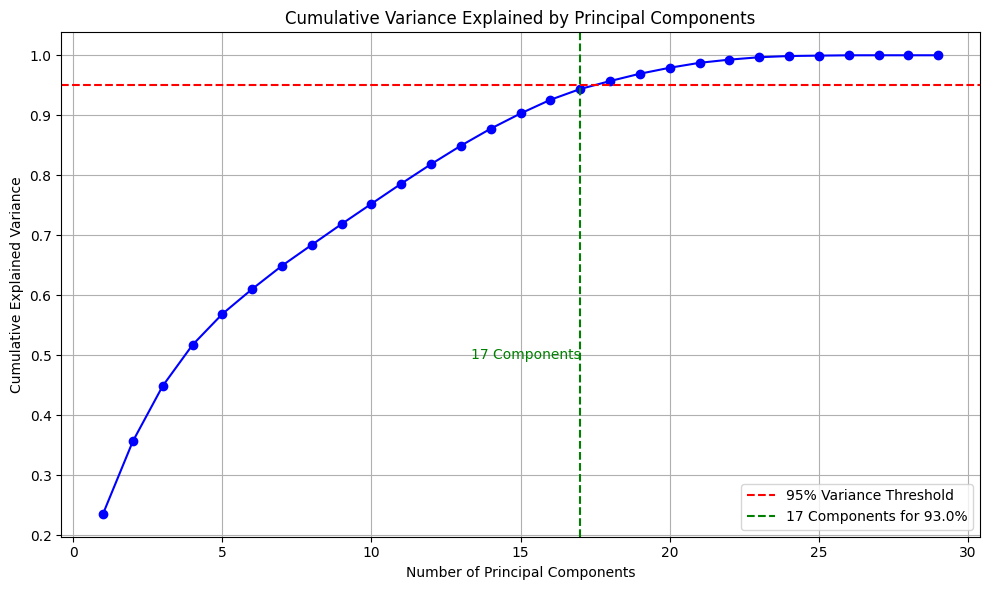

In [ ]:
# Step 1: Perform PCA. n_components is set to None
# to compute the variance explained by all possible principal components.
pca = PCA(n_components=None, random_state=42)
pca.fit(X_scaled)

# Step 2: Calculate cumulative variance.
# The 'explained_variance_ratio_' indicates the proportion of variance
# explained by each principal component.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Step 3: Create the cumulative variance plot.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
         marker='o', linestyle='-', color='b')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')

# Step 4: Identify the number of components required to exceed 95% variance.
n_components_95 = np.where(cumulative_variance >= var_exp)[0][0] + 1
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components for {var_exp * 100}%')
plt.text(n_components_95, 0.5, f'{n_components_95} Components', color='g', ha='right', va='center')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


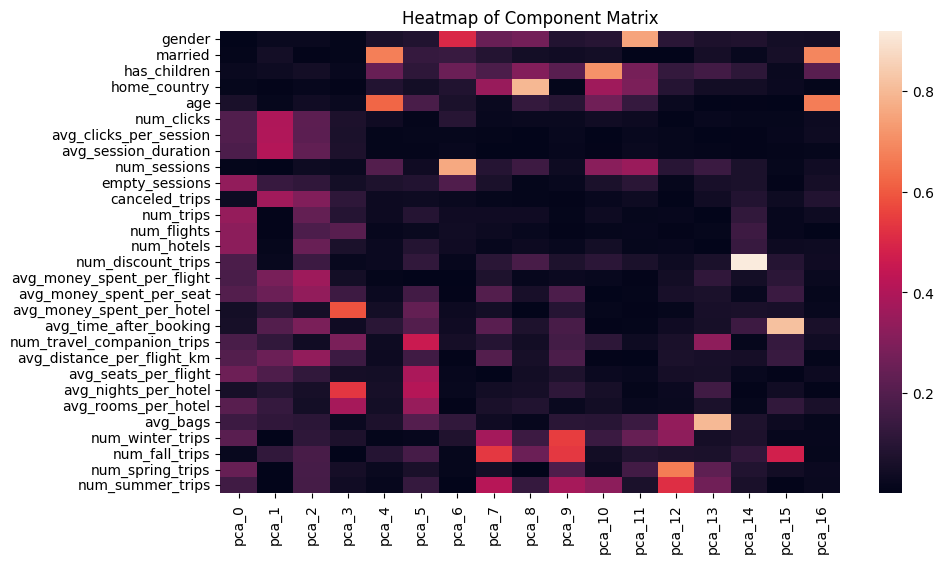

In [ ]:
# Examine which combination of variables contributes most to each principal component.
# This provides a clearer understanding of the structure and interpretation of the components.
plt.figure(figsize=(10,6))
sns.heatmap(np.abs(component_matrix))
plt.title('Heatmap of Component Matrix')
plt.show()

#<font color="mintblue">5. Silhouette-Score</font>

#<font color="mintblue">Principle of the Silhouette Score</font>

<font color="mintblue">The Silhouette Score is computed for each individual data point and assesses the quality of a clustering result based on two fundamental criteria.</font>

<font color="mintblue">1. Cohesion: refers to the average distance between a data point and all other points within the same cluster. Lower values indicate a higher degree of similarity between the data point and its assigned cluster.</font>

<font color="mintblue">2. Separation: refers to the average distance between a data point and all points in the nearest neighboring cluster. Higher values indicate stronger separation from other clusters and therefore better cluster distinctiveness.</font>

In [ ]:
# PCA DataFrame is used for the Silhouette Score
df_pca.head(2)

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16
user_id,,,,,,,,,,,,,,,,,
23557,-2.054113,-0.653685,-2.295509,3.009978,1.576372,-1.622691,-0.260012,-0.457816,-0.356132,-1.183669,-1.020088,-0.114097,-0.177952,-0.872906,0.504920,0.415528,-0.436477
94883,-0.836115,-1.758751,-0.581356,-0.368641,1.301008,1.605583,-0.217422,-0.198666,-0.631428,-0.961001,-1.571456,-0.585511,1.100700,-0.000433,-0.386304,0.043648,0.366777


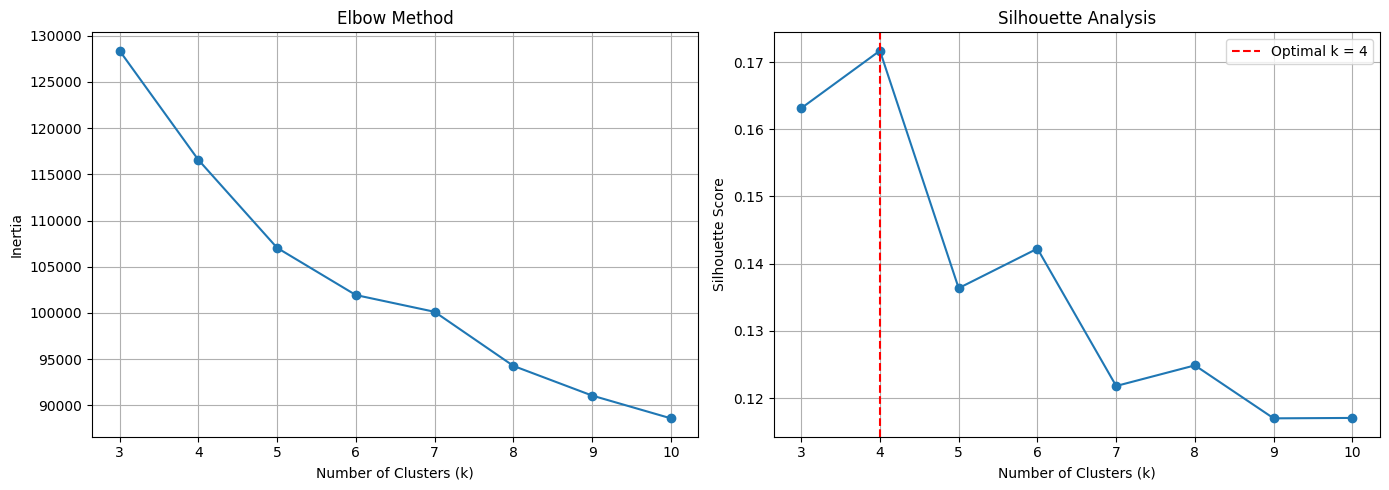

Optimal number of clusters based on Silhouette: 4


In [ ]:
# Define the range of cluster numbers to be evaluated (e.g., 3 to 10)
range_n_clusters = range(3, 11)
silhouette_scores = []
inertia_values = []

# Perform K-Means clustering for each value of k and compute the Silhouette Score
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca)
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertia_values.append(kmeans.inertia_)

# Identify the optimal number of clusters based on the highest Silhouette Score
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]

# Create subplots for the Elbow Method and Silhouette Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot to visualize inertia for different values of k
ax1.plot(range_n_clusters, inertia_values, marker='o')
ax1.set_title("Elbow Method")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.grid(True)

# Silhouette analysis plot
ax2.plot(range_n_clusters, silhouette_scores, marker='o')
ax2.axvline(optimal_n_clusters, color='red', linestyle='--',
            label=f'Optimal k = {optimal_n_clusters}')
ax2.set_title("Silhouette Analysis")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Output the optimal number of clusters based on the Silhouette Score
print(f"Optimal number of clusters based on Silhouette: {optimal_n_clusters}")


#<font color="mintblue">6. K-Means clustering</font>

<font color="mintblue">K-Means Clustering is an unsupervised learning algorithm used for data clustering, where unlabeled data points are grouped into distinct clusters. In this project, K-Means is applied to generate different segmentation structures with the objective of forming maximally distinct groups. The clustering process is based on the reduced feature space obtained through Principal Component Analysis (PCA) and is evaluated using the Silhouette Score to assess cluster separation and cohesion.</font>

<font color="mintblue">One of the main challenges in K-Means clustering is determining the optimal number of clusters, denoted by k. The average Silhouette Score across all data points can be used as an evaluation metric to compare different values of k. By performing K-Means clustering for multiple values of k (for example, from 2 to 10) and calculating the mean Silhouette Score for each configuration, the value of k that yields the highest average score is often considered the most suitable choice for the given dataset.</font>

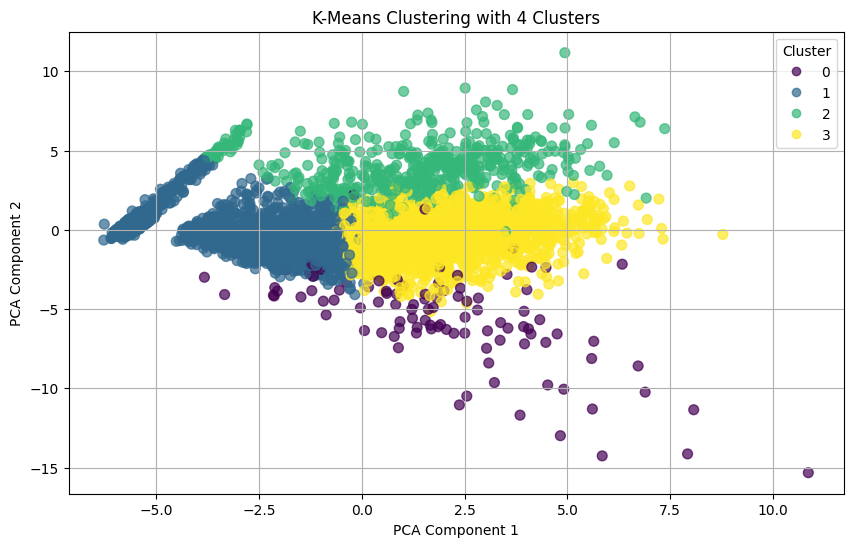

In [ ]:
# Perform K-Means clustering using the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
df_pca['group'] = kmeans.fit_predict(df_pca)

# Visualize the clusters using the first two principal components
# In practice, user_pca.iloc[:, 0] and user_pca.iloc[:, 1] represent the first two PCA dimensions
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_pca.iloc[:, 0],
    df_pca.iloc[:, 1],
    c=df_pca['group'],
    cmap='viridis',
    s=50,
    alpha=0.7
)

plt.title(f'K-Means Clustering with {optimal_n_clusters} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)

# Add a legend to indicate cluster assignments
legend = plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()


In [ ]:
# Create the result DataFrame for the K-Means Groups
df_user_segementation = df_pca['group']
# Display the K-Means Groups
df_user_segementation.head()

,group
user_id,
23557,1
94883,1
101486,1
101961,3
106907,2


#<font color="mintblue">7. Cluster Analysis</font>

<font color="mintblue">Customer segmentations were grouped by using the unsupervised machine learning algorithm K-Means. The resulting segments are subsequently analyzed and mapped to appropriate perks in order to design personalized offers that address the specific needs and preferences of each customer group.</font>

In [ ]:
# CSV import of user_base.csv
df_user_base = pd.read_csv(f'{directory}/user_base.csv')

#<font color="mintblue">7.1 Join of the final DataFrame 'df_customer_seg'</font>

In [ ]:
# Add the group assignment to the DataFrame 'df_user_base' from project part 1.
df_customer_seg = pd.merge(df_user_base, df_user_segementation, on='user_id')
# Display the final DataFrame
df_customer_seg.head().T

,0,1,2,3,4
user_id,23557,94883,101486,101961,106907
gender,F,F,F,F,F
married,True,True,True,True,True
has_children,False,False,True,False,True
home_country,usa,usa,usa,usa,usa
age,67,53,53,45,47
num_clicks,82,73,131,126,240
avg_clicks_per_session,10.25,9.125,16.375,15.75,30.0
avg_session_duration,76.625,67.75,122.25,117.75,241.5
num_sessions,8,8,8,8,8


#<font color="mintblue">7.2 Clean up the final DataFrame 'df_customer_seg'</font>

In [ ]:
# Remove the 'user_id' column, as it does not provide analytical value
# and may introduce noise into the results.
columns=['user_id']
df_customer_seg.drop(columns=columns, inplace=True)

In [ ]:
# Convert the values to integer format,
# like in Section 4.1.1 Handling of Non-Numerical Values
df_customer_seg['gender'] = df_customer_seg['gender'].map({'F': 0, 'M': 1, 'O': 2})
df_customer_seg['married'] = df_customer_seg['married'].astype(int)
df_customer_seg['has_children'] = df_customer_seg['has_children'].astype(int)
df_customer_seg['home_country'] = (df_customer_seg['home_country'] == 'usa').astype(int)
# Display the result
print(df_customer_seg.shape)
print(df_customer_seg.columns)
df_customer_seg.head(3)

(5998, 30)
Index(['gender', 'married', 'has_children', 'home_country', 'age',
       'num_clicks', 'avg_clicks_per_session', 'avg_session_duration',
       'num_sessions', 'empty_sessions', 'canceled_trips', 'num_trips',
       'num_flights', 'num_hotels', 'num_discount_trips',
       'avg_money_spent_per_flight', 'avg_money_spent_per_seat',
       'avg_money_spent_per_hotel', 'avg_time_after_booking',
       'num_travel_companion_trips', 'avg_distance_per_flight_km',
       'avg_seats_per_flight', 'avg_nights_per_hotel', 'avg_rooms_per_hotel',
       'avg_bags', 'num_winter_trips', 'num_fall_trips', 'num_spring_trips',
       'num_summer_trips', 'group'],
      dtype='object')


,gender,married,has_children,home_country,age,num_clicks,avg_clicks_per_session,avg_session_duration,num_sessions,empty_sessions,...,avg_distance_per_flight_km,avg_seats_per_flight,avg_nights_per_hotel,avg_rooms_per_hotel,avg_bags,num_winter_trips,num_fall_trips,num_spring_trips,num_summer_trips,group
0,0,1,0,1,67,82,10.250,76.625,8,6,...,0.00,0.0,10.0,1.5,0.0,0.0,0.0,1.0,1.0,1
1,0,1,0,1,53,73,9.125,67.750,8,6,...,1453.65,1.5,0.5,1.5,0.5,0.0,0.0,2.0,0.0,1
2,0,1,1,1,53,131,16.375,122.250,8,6,...,965.30,1.0,4.0,1.5,0.0,0.0,0.0,0.0,2.0,1


#<font color="mintblue">7.3 CSV Export of the final DataFrame 'df_customer_seg'</font>

In [ ]:
# CSV export
df_customer_seg.to_csv(f'{directory}/customer_segmentation.csv', index=False)

#<font color="mintblue">7.4 EDA of the final DataFrame 'df_customer_seg'</font>

In [ ]:
# Overviews of the DataFrame'df_customer_seg'
#print(df_customer_seg.columns)
#print(df_customer_seg.info())
print(df_customer_seg.shape)
print(df_customer_seg.dtypes)
print(df_customer_seg.isnull().sum())

(5998, 30)
gender                          int64
married                         int64
has_children                    int64
home_country                    int64
age                             int64
num_clicks                      int64
avg_clicks_per_session        float64
avg_session_duration          float64
num_sessions                    int64
empty_sessions                  int64
canceled_trips                  int64
num_trips                     float64
num_flights                   float64
num_hotels                      int64
num_discount_trips            float64
avg_money_spent_per_flight    float64
avg_money_spent_per_seat      float64
avg_money_spent_per_hotel     float64
avg_time_after_booking        float64
num_travel_companion_trips    float64
avg_distance_per_flight_km    float64
avg_seats_per_flight          float64
avg_nights_per_hotel          float64
avg_rooms_per_hotel           float64
avg_bags                      float64
num_winter_trips              float64
n

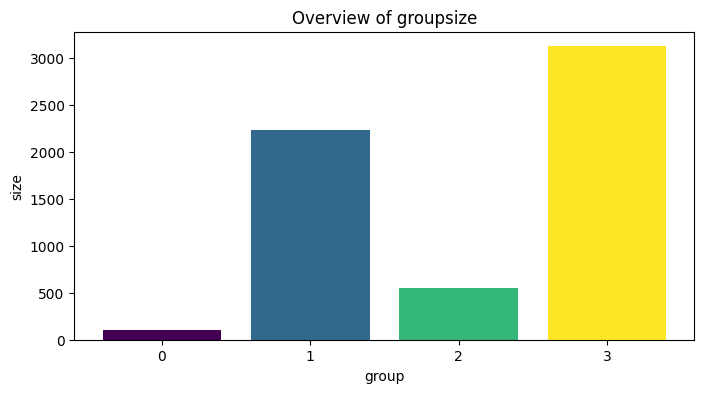

In [ ]:
# bar plot to show the size of the groups
# definition
counts = df_customer_seg['group'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(counts)))

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(counts.index, counts.values, color=colors)

# labels
ax.set_xlabel("group")
ax.set_ylabel("size")
ax.set_title("Overview of groupsize")

# x-values
ax.set_xticks(counts.index)
ax.set_xticklabels(counts.index.astype(int), rotation=0)

plt.show()

In [ ]:
# Grouping the DataFrame to the column 'group' to create a heatmap
df_customer_seg.groupby('group').size()

,0
group,
0,102
1,2227
2,548
3,3121


In [ ]:
def plot_box(df, cat_col, num_col):
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=df,
        x=cat_col,
        y=num_col,
        hue=cat_col,
        palette='viridis',
        legend=False
    )
    plt.title(f'{num_col} by {cat_col}')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_all_boxplots(df, cat_col):
    num_cols = df.select_dtypes(include='number').columns

    for i, num_col in enumerate(num_cols, start=1):
        if num_col != cat_col:
            print(f'Plot {i}/{len(num_cols)}: {num_col}')
            plot_box(df, cat_col, num_col)


Plot 1/30: gender


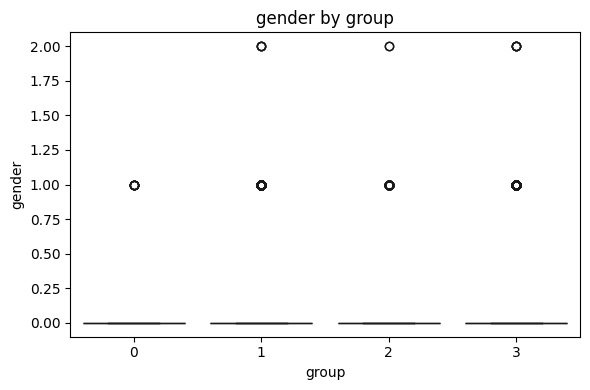

Plot 2/30: married


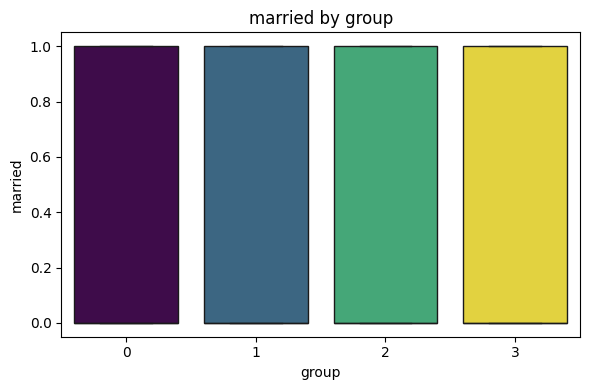

Plot 3/30: has_children


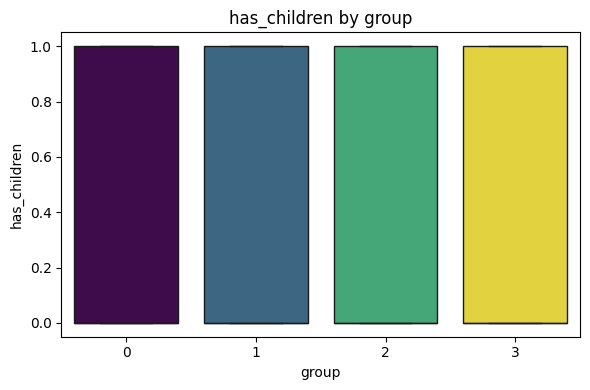

Plot 4/30: home_country


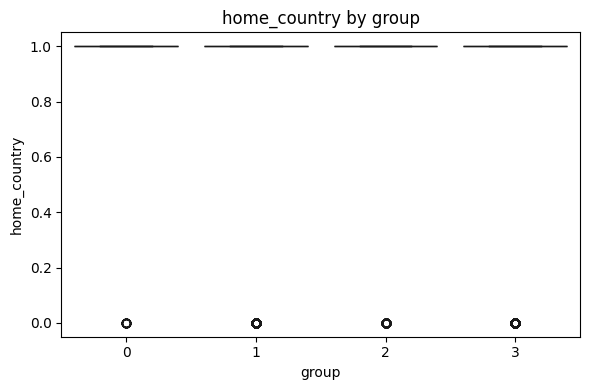

Plot 5/30: age


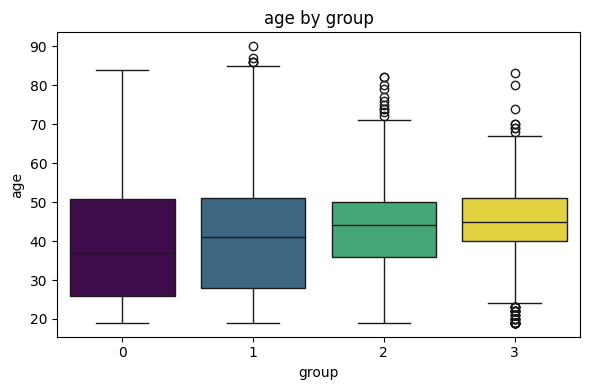

Plot 6/30: num_clicks


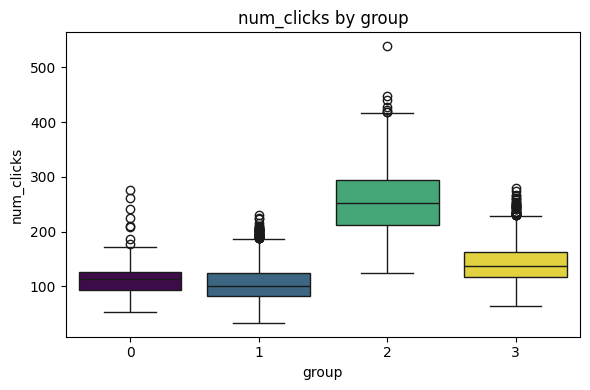

Plot 7/30: avg_clicks_per_session


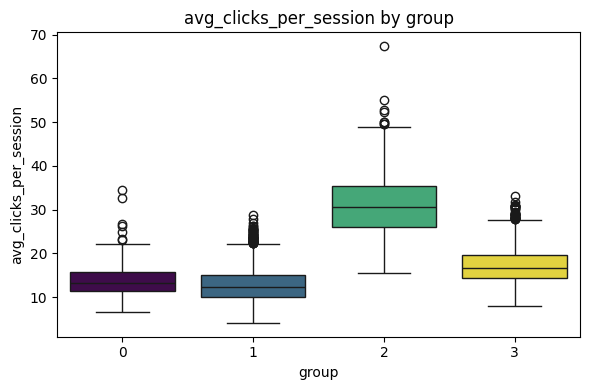

Plot 8/30: avg_session_duration


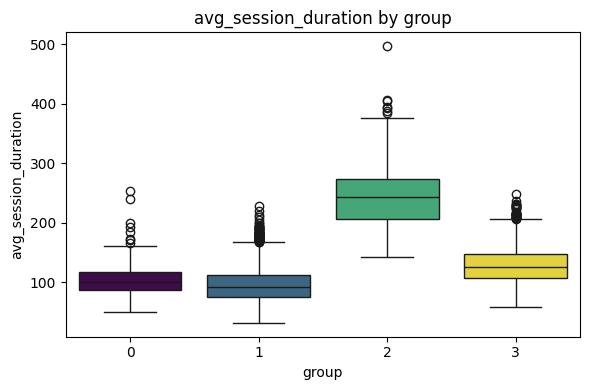

Plot 9/30: num_sessions


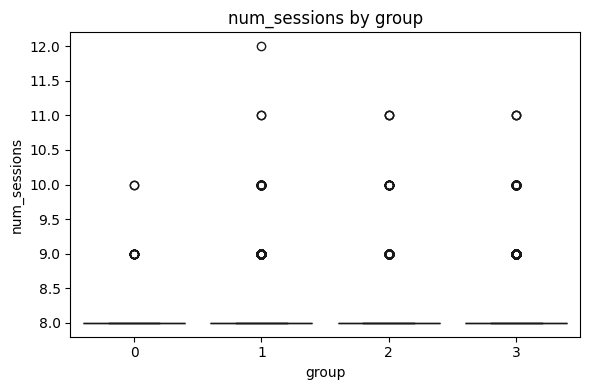

Plot 10/30: empty_sessions


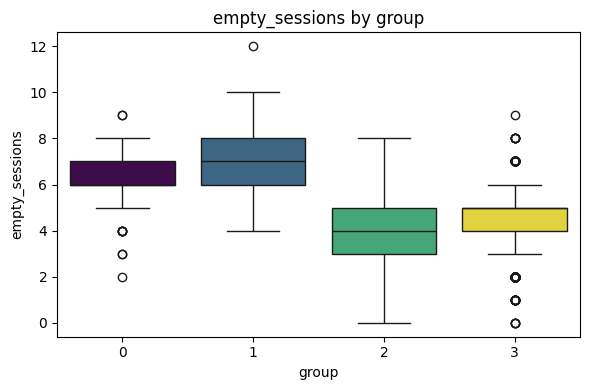

Plot 11/30: canceled_trips


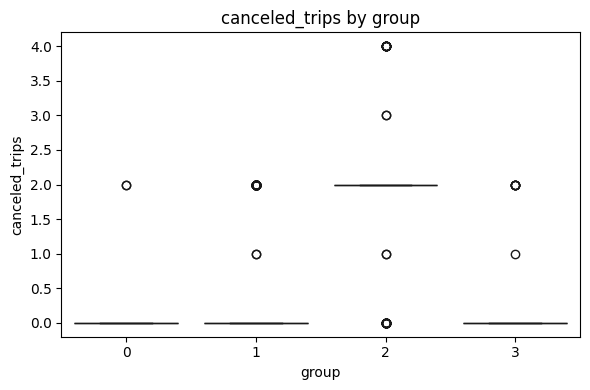

Plot 12/30: num_trips


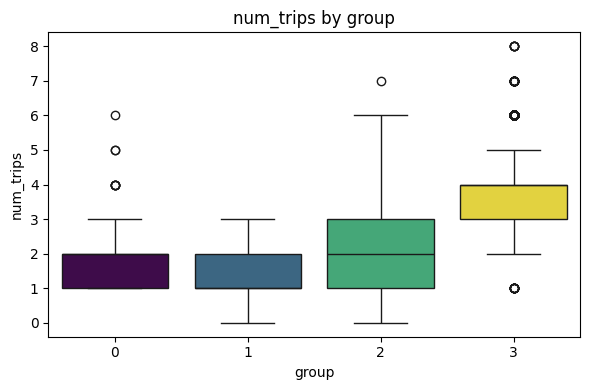

Plot 13/30: num_flights


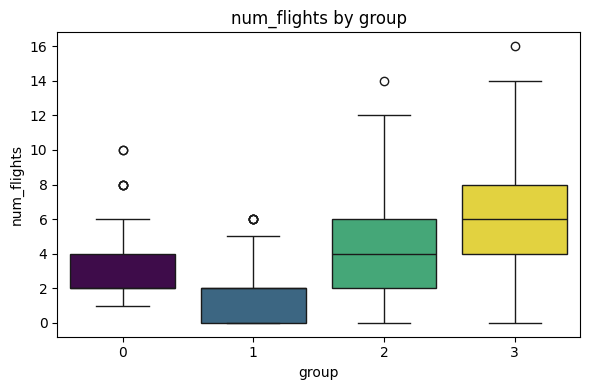

Plot 14/30: num_hotels


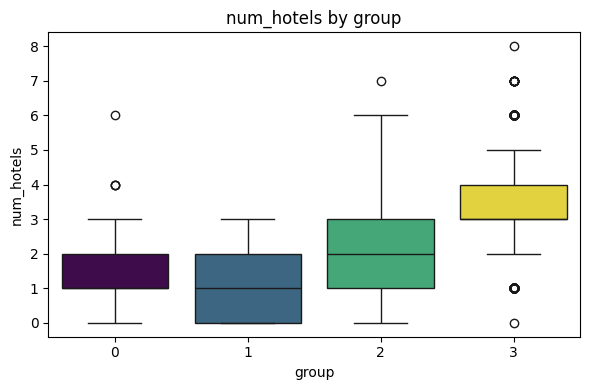

Plot 15/30: num_discount_trips


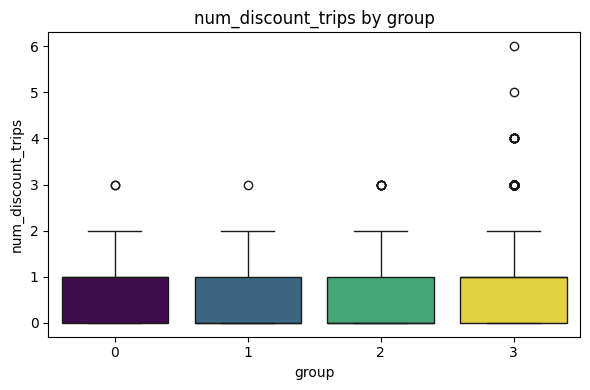

Plot 16/30: avg_money_spent_per_flight


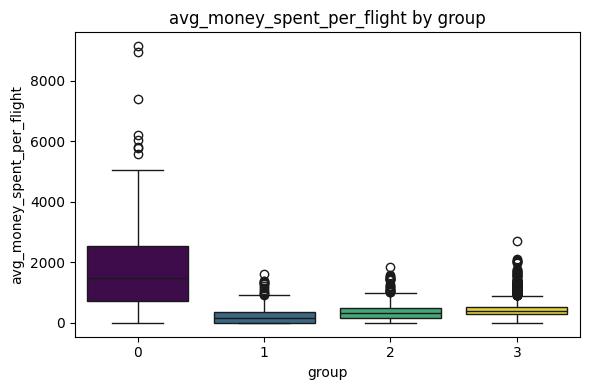

Plot 17/30: avg_money_spent_per_seat


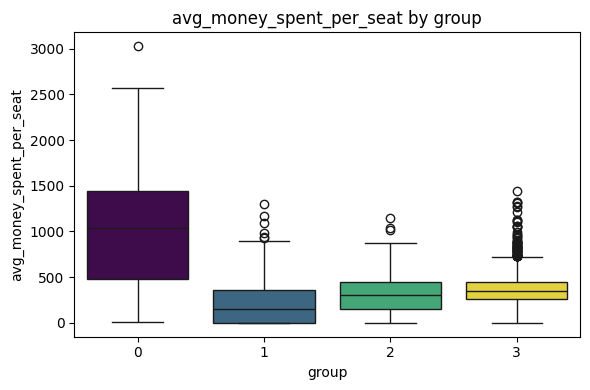

Plot 18/30: avg_money_spent_per_hotel


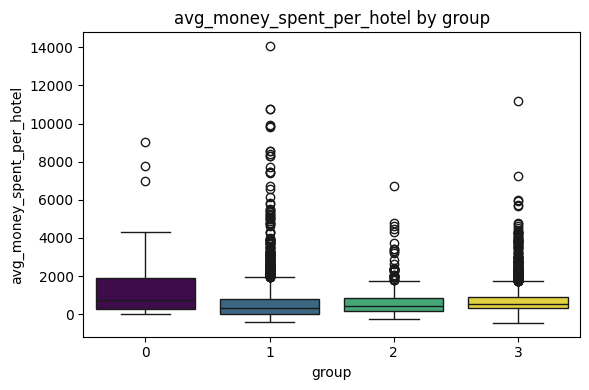

Plot 19/30: avg_time_after_booking


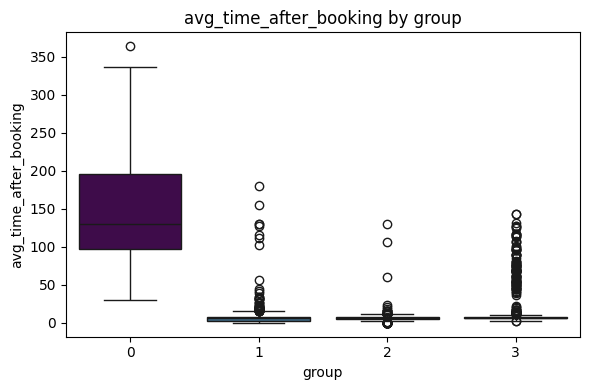

Plot 20/30: num_travel_companion_trips


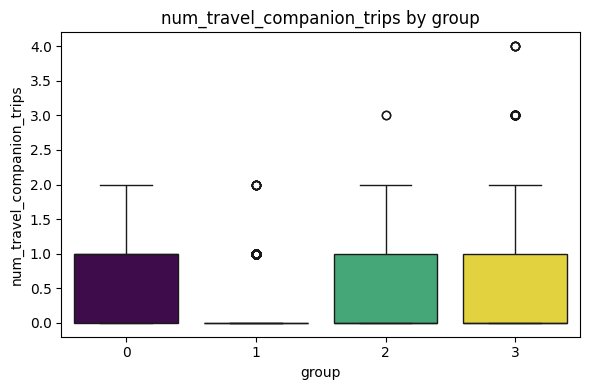

Plot 21/30: avg_distance_per_flight_km


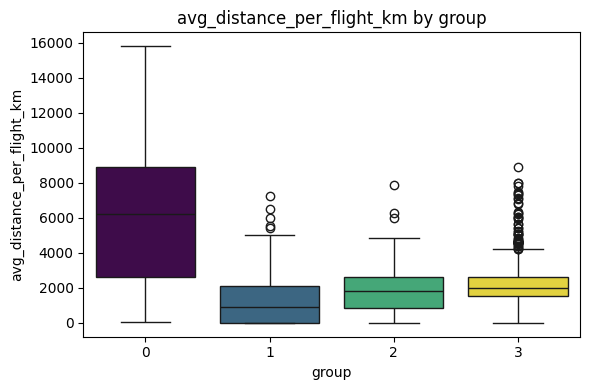

Plot 22/30: avg_seats_per_flight


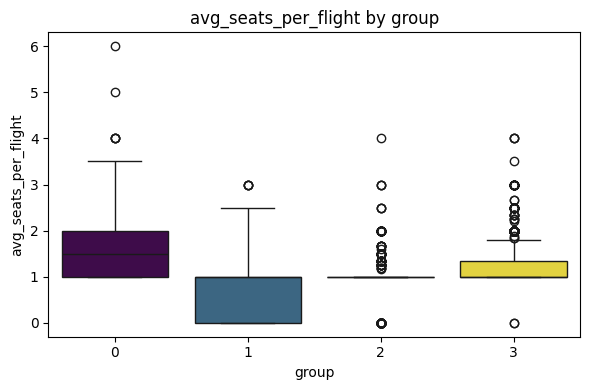

Plot 23/30: avg_nights_per_hotel


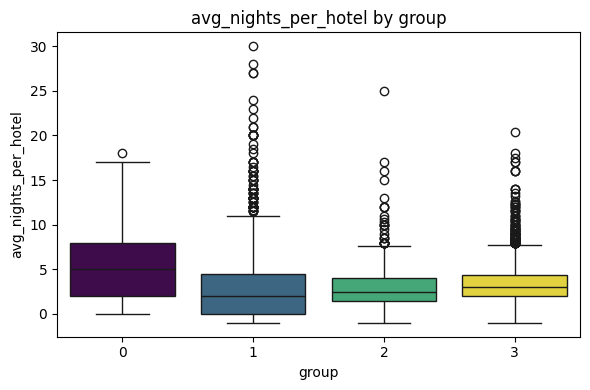

Plot 24/30: avg_rooms_per_hotel


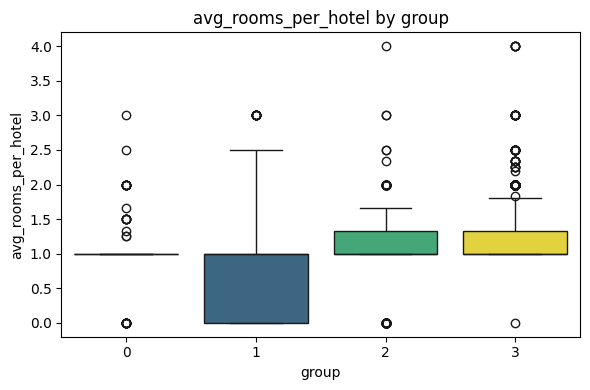

Plot 25/30: avg_bags


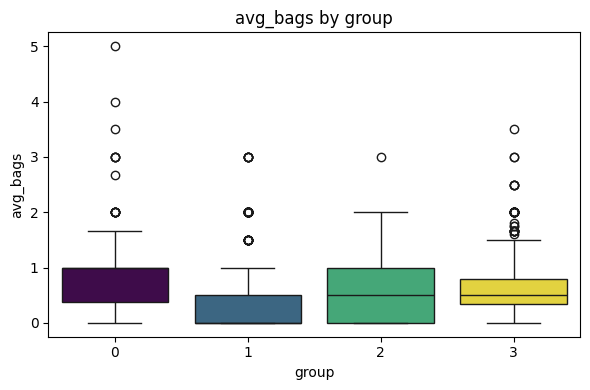

Plot 26/30: num_winter_trips


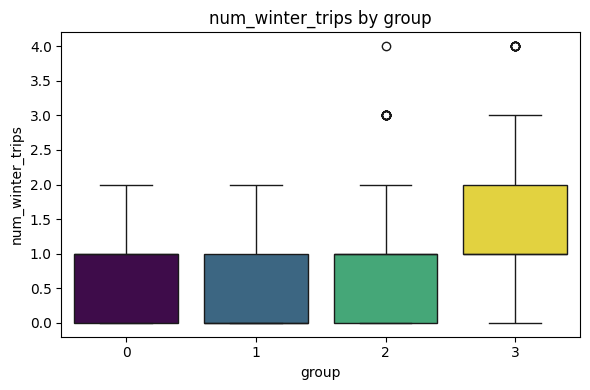

Plot 27/30: num_fall_trips


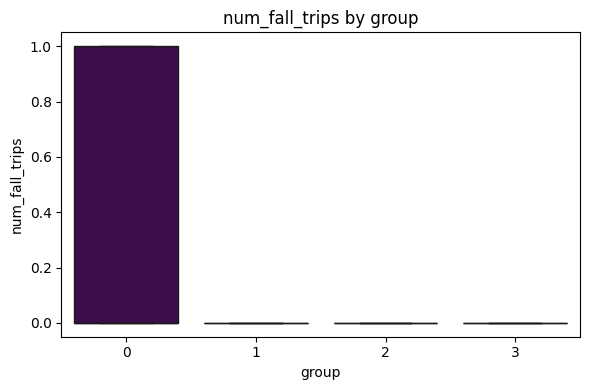

Plot 28/30: num_spring_trips


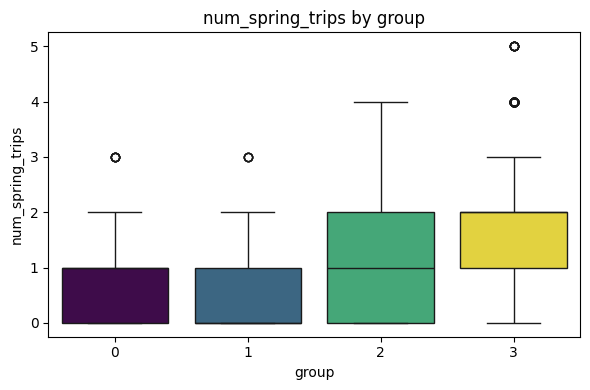

Plot 29/30: num_summer_trips


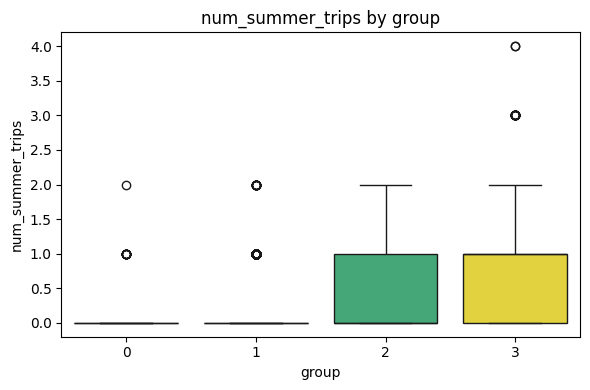

In [ ]:
plot_all_boxplots(df_customer_seg, cat_col='group')


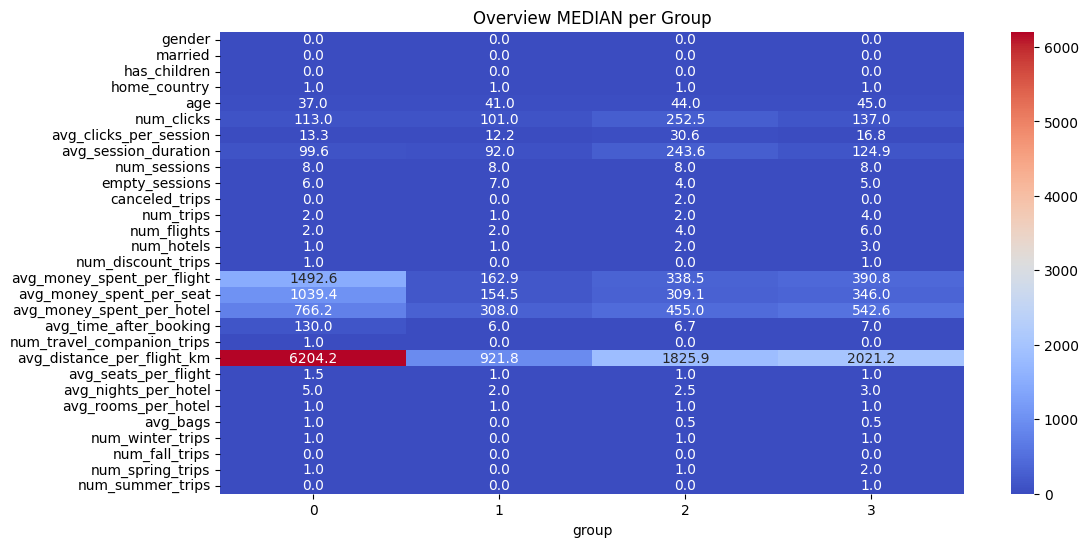

In [ ]:
# Heatmap of group MEDIAN per group
group_summary_median = df_customer_seg.groupby("group").median(numeric_only=True).T
group_summary_median
plt.figure(figsize=(12, 6))
sns.heatmap(group_summary_median, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Overview MEDIAN per Group")
plt.show()

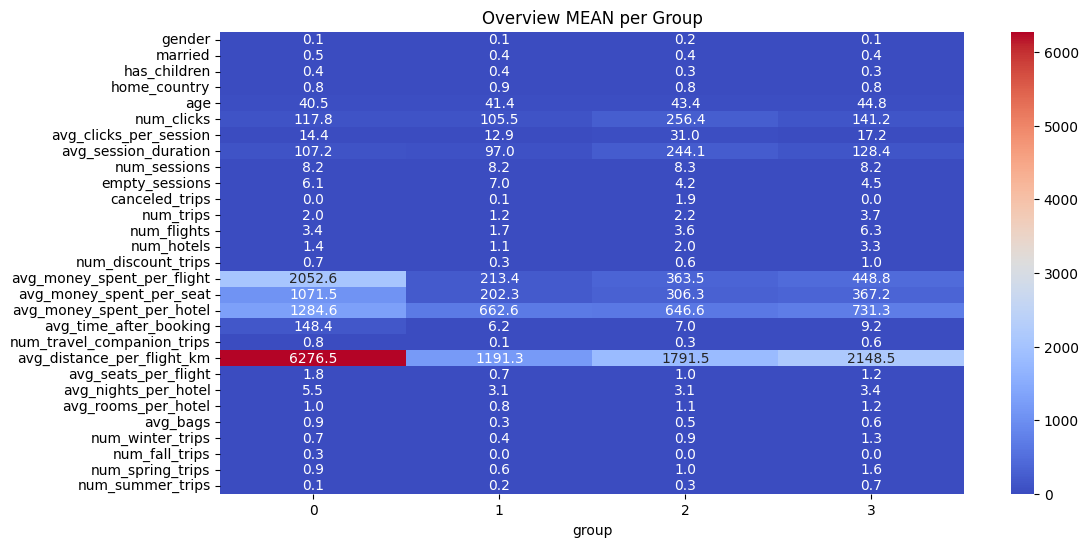

In [ ]:
# Heatmap of MEAN per group
group_summary_mean = df_customer_seg.groupby("group").mean(numeric_only=True).T
plt.figure(figsize=(12, 6))
sns.heatmap(group_summary_mean, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Overview MEAN per Group")
plt.show()

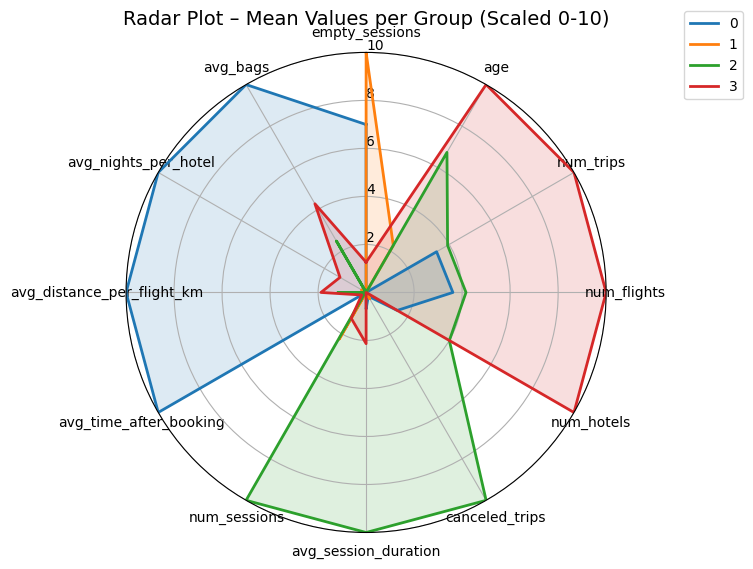

In [ ]:
# Radar-Plot of the Groups with manual selection of features

# Create a copy of the input data: rows=features, columns=groups with mean values
data = group_summary_mean.copy()

# === Manual Feature Selection ===
selected_features = [

    "empty_sessions",
    "age",
    "num_trips",
    "num_flights",
    "num_hotels",
    "canceled_trips",
    "avg_session_duration",
    "num_sessions",
    "avg_time_after_booking",
    "avg_distance_per_flight_km",
    "avg_nights_per_hotel",
    "avg_bags"
]

# Filter to only include features that exist in the dataset
selected_features = [f for f in selected_features if f in data.index]
data = data.loc[selected_features]

# === Automatic Min-Max Scaling per Feature to 0-10 Range ===
# Calculate global min/max values for each feature across all groups
feature_mins = data.min(axis=1)
feature_maxs = data.max(axis=1)

data_scaled = data.copy()

# Apply linear min-max scaling for each feature: (x - min) / (max - min) * 10
for feat in data_scaled.index:
    min_f = feature_mins.loc[feat]
    max_f = feature_maxs.loc[feat]
    rng = max_f - min_f if max_f != min_f else 1  # Prevent division by zero

    # Scale feature values to 0-10 range using global min/max
    data_scaled.loc[feat] = (data_scaled.loc[feat] - min_f) / rng * 10

# === Radar Chart Construction ===
# Prepare angular coordinates for radar chart axes
labels = data_scaled.index.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle by appending first angle

# Create polar subplot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each group as a separate radar line with filled area
for group in data_scaled.columns:
    values = data_scaled[group].values.tolist()
    values += values[:1]  # Complete the circle for this group

    ax.plot(angles, values, linewidth=2, label=str(group))
    ax.fill(angles, values, alpha=0.15)

# Configure radar chart display properties
ax.set_theta_offset(np.pi / 2)      # Start axis at 12 o'clock position
ax.set_theta_direction(-1)          # Clockwise direction
ax.set_thetagrids(np.degrees(angles[:-1]), labels)  # Set feature labels
ax.set_rlabel_position(0)           # Radial labels position
ax.set_ylim(0, 10)                  # Fix radial scale to 0-10 range

# Finalize plot layout and styling
plt.title("Radar Plot – Mean Values per Group (Scaled 0-10)", size=14, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


#<font color="mintblue">7.5 Manual evaluation
<font color="mintblue">Based on the previous results of the k-means clustering, manual group formation was carried out, followed by the corresponding assignment of perks.


| Cluster | Group Specification     |Recommended Perk                   
| ------- | -----------------------------------------------| ---------------------------------- |
| **0**   | Premium Travelers   | **1 night free hotel with flight** |
| **1**   | Deal Seekers   | **Exclusive discounts** |
| **2**   | Undecided Travelers   | **No cancellation fees** |
| **3**   | Frequent Travelers   | **Free checked bag 'or' free hotel meal** |
